# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from IPython.display import display
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [5]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

In [7]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 100):
    display(azdias)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,-1,3,2,5.0,1,4,2,5,4,4,1,1976,12.0,0,3,2.0,1.0,1.0,1.0,2.0,1.0,1,14,3.0,2,1,3,3,2,1,6,3,4,4,7,5,4,2,3,0.0,0.0,1,4,17.0,1.0,0.0,4.0,3.0,3.0,4.0,15.0,0.0,8.0,3.0,1992.0,W,3.0,7,7A,41,2.0,1.0,0.0,0.0,0.0,4.0,6.0,3.0,7.0,4.0,3.0,5.0,5.0,5.0,282.0,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,6,1970,1.0,0,-1,2.0,1.0,1.0,1.0,1.0,1.0,0,10,5.0,4,4,7,5,4,7,7,4,4,4,4,4,6,2,-1,0.0,0.0,-1,6,16.0,1.0,0.0,6.0,NaN,6.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,5.0,9,9D,51,0.0,0.0,1.0,1.0,5.0,2.0,7.0,6.0,2.0,3.0,3.0,1.0,2.0,7.0,592.0,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,1,1976,10.0,0,1,0.0,0.0,0.0,0.0,4.0,2.0,1,14,4.0,5,2,5,3,2,3,5,5,7,4,4,5,6,7,2,0.0,0.0,1,4,17.0,0.0,0.0,5.0,NaN,NaN,5.0,3.0,0.0,8.0,6.0,1992.0,W,7.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,5.0,2.0,6.0,4.0,3.0,2.0,3.0,5.0,688.0,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,1,1994,9.0,0,1,29.0,9.0,9.0,5.0,2.0,1.0,1,14,4.0,7,7,7,5,6,3,2,7,5,2,2,2,7,5,0,0.0,0.0,2,5,0.0,1.0,0.0,6.0,NaN,1.0,9.0,7.0,0.0,8.0,2.0,1992.0,W,5.0,9,9D,51,0.0,3.0,2.0,0.0,0.0,3.0,2.0,6.0,4.0,4.0,4.0,1.0,3.0,7.0,134.0,1.0,4.0,3.0,1.0,5.0,1.0

In [8]:
# azdias.describe()
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [9]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 4):
    display(feat_info)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [10]:
# feat_info.describe()
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.8+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [52]:
# Identify missing or unknown data values and convert them to NaNs.

In [53]:
# Check how many missing (not unknown) values in azdias
azdias_missing_unknown = azdias.isnull().sum()
with pd.option_context('display.max_rows', 100, 'display.max_columns', 2):
    display(azdias_missing_unknown)

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [54]:
# Check format of missing values in feat_info
display(feat_info['missing_or_unknown'])

0       [-1,0]
1     [-1,0,9]
2       [-1,0]
3          [0]
4         [-1]
        ...   
80        [-1]
81        [-1]
82      [-1,9]
83      [-1,0]
84      [-1,9]
Name: missing_or_unknown, Length: 85, dtype: object

In [55]:
feat_info['missing_or_unknown'][0]

'[-1,0]'

##### Observations:
Values in azdias are mostly floats. Missing values from feat_info are strings.  
To replace the missing float values in azdias, I need to compare them with float values.  
Similarly, to replace the missing string values ('', 'X', and 'XX') in azdias, I need to compare them with string values.  
Therefore, I need to convert the string from feat_info into a list of floats and strings. 

In [56]:
# Step 1: Remove '[' and ']'
missing_unknown_values_temp = feat_info['missing_or_unknown'].replace(to_replace=['\[', '\]'], value='', regex=True)
print('Step 1:')
display(missing_unknown_values_temp[0:5])

# Step 2: Split values by ',' to create a list of int
missing_unknown_values = []
for value in range(len(missing_unknown_values_temp)):
    missing_unknown_values.append(missing_unknown_values_temp[value].split(','))
print('Step 2:')
display(missing_unknown_values[:5])
    
# Step 3: Convert values to float (only possible from ints, not strings)
for i in range(len(missing_unknown_values)):  # Iterate over all features 
    for j in range(len(missing_unknown_values[i])):  # Iterate over all missing values for each feature 
        
        # Don't touch the missing values already in string format 
        if missing_unknown_values[i][j] in ['', 'X', 'XX']:
            pass
        
        # Convert the ints into floats 
        else: 
            missing_unknown_values[i][j] = float(missing_unknown_values[i][j])
print('Step 3:')
display(missing_unknown_values)

Step 1:


0      -1,0
1    -1,0,9
2      -1,0
3         0
4        -1
Name: missing_or_unknown, dtype: object

Step 2:


[['-1', '0'], ['-1', '0', '9'], ['-1', '0'], ['0'], ['-1']]

Step 3:


[[-1.0, 0.0],
 [-1.0, 0.0, 9.0],
 [-1.0, 0.0],
 [0.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [0.0],
 [''],
 [''],
 [-1.0, 0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [-1.0, 0.0],
 [-1.0, 0.0],
 [0.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0],
 [-1.0, 9.0],
 [0.0],
 [''],
 [''],
 [-1.0, 0.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0, 0.0],
 [0.0],
 [''],
 [-1.0, 0.0],
 [''],
 [0.0],
 [-1.0],
 [-1.0],
 [-1.0, 'X'],
 ['XX'],
 [-1.0, 'XX'],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0, 0.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [''],
 [-1.0, 0.0],
 [''],
 [''],
 [-1.0, 0.0],
 [''],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0],
 [-1.0],
 [-1.0, 9.0],
 [-1.0, 0.0],
 [-1.0, 9.0]]

In [57]:
# Fill missing values in azdias with NaN using missing_values
for values in range(len(missing_unknown_values)):  # Iterate over all features
    
    # Saving column name
    column_name = feat_info.iloc[values]['attribute']
    
    # Replace all values in the columns (features) of azdias that are in missing values, with NaN
    azdias[column_name].replace(missing_unknown_values[values], np.nan, inplace=True) 

display(azdias)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,NaN,3.0,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,NaN,2.0,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,NaN,2.0,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,NaN,1.0,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [58]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Calculate missing values after replacing necessary values in azdias
azdias_missing_unknown_after_update = azdias.isnull().sum()

# Create dataframe from number of originally missing values and number of updated missing values 
s1 = pd.Series(azdias_missing_unknown, name="Initially missing")
s2 = pd.Series(azdias_missing_unknown_after_update, name="Missing after update")
s = pd.concat([s1, s2], axis=1)

with pd.option_context('display.max_rows', 100, 'display.max_columns', 2):
    display(s)

,Initially missing,Missing after update
AGER_TYP,685843,685843
ALTERSKATEGORIE_GROB,2881,2881
ANREDE_KZ,0,0
CJT_GESAMTTYP,4854,4854
FINANZ_MINIMALIST,0,0
FINANZ_SPARER,0,0
FINANZ_VORSORGER,0,0
FINANZ_ANLEGER,0,0
FINANZ_UNAUFFAELLIGER,0,0
FINANZ_HAUSBAUER,0,0


In [59]:
# Investigate patterns in the amount of missing data in each column.

# Number of samples 
num_samples = azdias.shape[0]

# Create Dataframe of percentage of missing values after update 
azdias_missing_unknown_after_update_dataframe = pd.DataFrame(azdias_missing_unknown_after_update, 
                                                             columns = ['Percentage of missing values after update'])
percentage_missing_values = (azdias_missing_unknown_after_update_dataframe/num_samples)*100
display(percentage_missing_values)

,Percentage of missing values after update
AGER_TYP,76.955435
ALTERSKATEGORIE_GROB,0.323264
ANREDE_KZ,0.000000
CJT_GESAMTTYP,0.544646
FINANZ_MINIMALIST,0.000000
...,...
PLZ8_HHZ,13.073637
PLZ8_GBZ,13.073637
ARBEIT,10.926022
ORTSGR_KLS9,10.914689


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132dafa20>]],
      dtype=object)

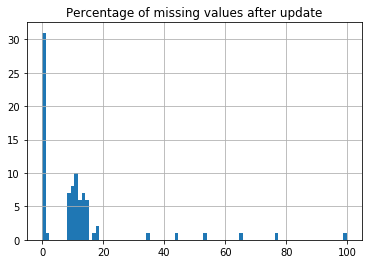

In [60]:
# Visualize distribution of percentage of missing value counts
percentage_missing_values.hist(bins=85)

In [61]:
# Let's see which features miss more than 10% of data 
percentage_missing_values_2 = percentage_missing_values[percentage_missing_values['Percentage of missing values after update'] > 10.0]
display(percentage_missing_values_2)
print('percentage_missing_values_2.shape:', percentage_missing_values_2.shape)

,Percentage of missing values after update
AGER_TYP,76.955435
GEBURTSJAHR,44.020282
HEALTH_TYP,12.476816
LP_LEBENSPHASE_FEIN,10.954859
LP_LEBENSPHASE_GROB,10.611509
NATIONALITAET_KZ,12.153551
PRAEGENDE_JUGENDJAHRE,12.136608
SHOPPER_TYP,12.476816
TITEL_KZ,99.757636
VERS_TYP,12.476816


percentage_missing_values_2.shape: (46, 1)


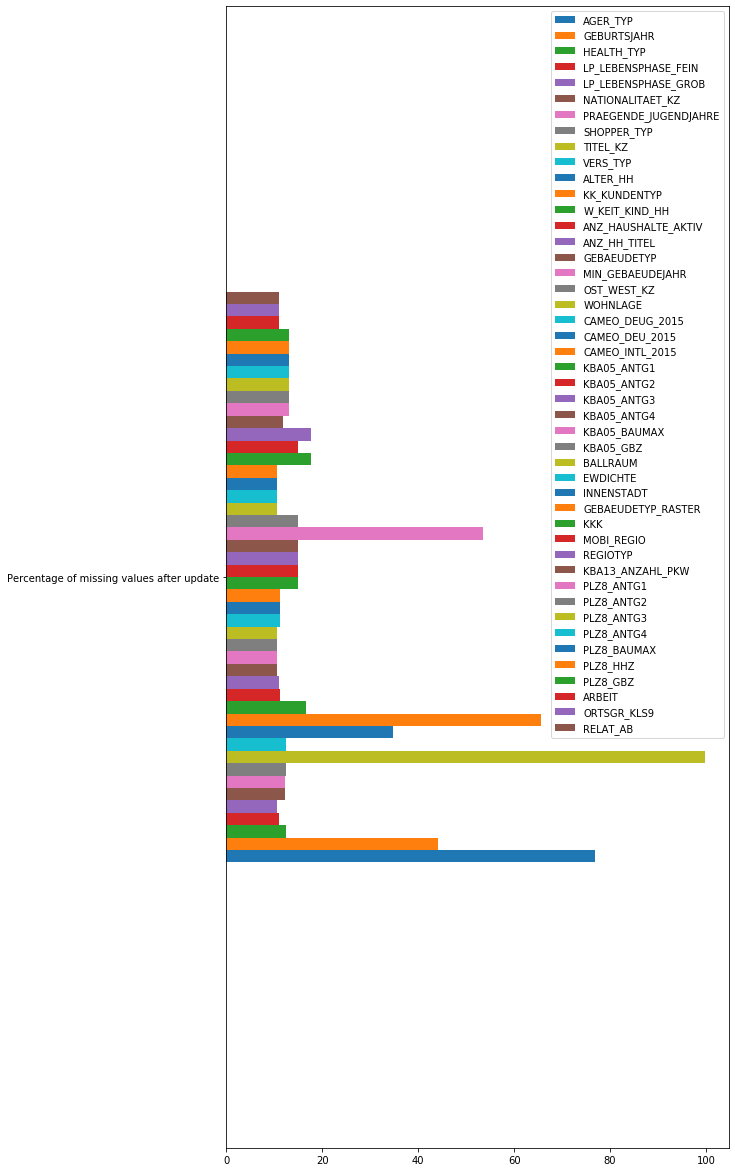

In [62]:
# Plot features that are missing more than 10% of data 
percentage_missing_values_2.transpose().plot(kind='barh', figsize=(9,21))

In [63]:
# Drop outliers (features that are missing more than 20% of data)
outliers = percentage_missing_values[percentage_missing_values['Percentage of missing values after update'] > 20.0]
outliers = outliers.transpose()
display(outliers)

,AGER_TYP,GEBURTSJAHR,TITEL_KZ,ALTER_HH,KK_KUNDENTYP,KBA05_BAUMAX
Percentage of missing values after update,76.955435,44.020282,99.757636,34.813699,65.596749,53.468668


In [64]:
# Find indices of outliers

# Values that contain outlier's features names will be marked as True, otherwise False
feat_info_outlier_idx = feat_info.isin(outliers.columns.values.tolist()) 
print(feat_info_outlier_idx)

    attribute  information_level   type  missing_or_unknown
0        True              False  False               False
1       False              False  False               False
2       False              False  False               False
3       False              False  False               False
4       False              False  False               False
..        ...                ...    ...                 ...
80      False              False  False               False
81      False              False  False               False
82      False              False  False               False
83      False              False  False               False
84      False              False  False               False

[85 rows x 4 columns]


In [65]:
# Print indices of outliers
print('Indices of outliers:', feat_info_outlier_idx[feat_info_outlier_idx.attribute==True].index.values.tolist())

Indices of outliers: [0, 11, 40, 43, 47, 64]


##### Observations:
There are 46/85 features that are missing (or contain NaN) in more than 10% of data, and 6/85 features that are missing (or contain NaN) in more than 20% data.  
The outlier features are:
- AGER_TYP: ~76%
- GEBURTSJAHR: ~44%
- TITEL_KZ: ~99%
- ALTER_HH: ~34%
- KK_KUNDENTYP: ~65%
- KBA05_BAUMAX: ~53%  

These features will be removed from the dataset. 

In [66]:
# Remove the outlier columns from the dataset (azdias). (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias_no_outliers = azdias.drop(outliers, axis=1)
display(azdias_no_outliers)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,5.0,1,4,2,5,4,4,1,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,2.0,1,4.0,3,3,3,2,2,3,6,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,2.0,2,4.0,2,4,2,5,4,3,1,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,1.0,1,3.0,1,5,3,5,5,5,1,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


In [67]:
# Removing outliers from feat_info 

# Dropping rows from feat_info where corresponding row of feat_info_idx is equal to True. 
feat_info_no_outliers = feat_info.drop(feat_info_outlier_idx[feat_info_outlier_idx.attribute == True].index) 
display(feat_info_no_outliers)

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


In [68]:
# Check columsn without any missing values
azdias_no_missing_values = percentage_missing_values[percentage_missing_values['Percentage of missing values after update'] == 0.0]
display(azdias_no_missing_values)
print('There are {0} features with no missing values'.format(azdias_no_missing_values.shape[0]))

,Percentage of missing values after update
ANREDE_KZ,0.0
FINANZ_MINIMALIST,0.0
FINANZ_SPARER,0.0
FINANZ_VORSORGER,0.0
FINANZ_ANLEGER,0.0
FINANZ_UNAUFFAELLIGER,0.0
FINANZ_HAUSBAUER,0.0
FINANZTYP,0.0
GREEN_AVANTGARDE,0.0
SEMIO_SOZ,0.0


There are 24 features with no missing values


In [69]:
# Group features that have the same number of missing values 
azdias_missing_unknown_after_update_dataframe = azdias_missing_unknown_after_update_dataframe.rename(index=str, 
                                                                                                     columns={'Percentage of missing values after update': 'Number of missing values'})

for num_missing_values in azdias_missing_unknown_after_update_dataframe.groupby(['Number of missing values']):
    display(num_missing_values)

(0,                        Number of missing values
 ANREDE_KZ                                     0
 FINANZ_MINIMALIST                             0
 FINANZ_SPARER                                 0
 FINANZ_VORSORGER                              0
 FINANZ_ANLEGER                                0
 FINANZ_UNAUFFAELLIGER                         0
 FINANZ_HAUSBAUER                              0
 FINANZTYP                                     0
 GREEN_AVANTGARDE                              0
 SEMIO_SOZ                                     0
 SEMIO_FAM                                     0
 SEMIO_REL                                     0
 SEMIO_MAT                                     0
 SEMIO_VERT                                    0
 SEMIO_LUST                                    0
 SEMIO_ERL                                     0
 SEMIO_KULT                                    0
 SEMIO_RAT                                     0
 SEMIO_KRIT                                    0
 SEMIO_DOM       

(2881,                       Number of missing values
 ALTERSKATEGORIE_GROB                      2881)

(4854,                    Number of missing values
 CJT_GESAMTTYP                          4854
 GFK_URLAUBERTYP                        4854
 LP_STATUS_FEIN                         4854
 LP_STATUS_GROB                         4854
 RETOURTYP_BK_S                         4854
 ONLINE_AFFINITAET                      4854)

(18348,                     Number of missing values
 HH_EINKOMMEN_SCORE                     18348)

(73499,                 Number of missing values
 SOHO_KZ                            73499
 ANZ_PERSONEN                       73499
 ANZ_TITEL                          73499
 WOHNDAUER_2008                     73499)

(73969,              Number of missing values
 KONSUMNAEHE                     73969)

(77792,                  Number of missing values
 LP_FAMILIE_FEIN                     77792
 LP_FAMILIE_GROB                     77792)

(93148,                   Number of missing values
 GEBAEUDETYP                          93148
 MIN_GEBAEUDEJAHR                     93148
 OST_WEST_KZ                          93148
 WOHNLAGE                             93148)

(93155,                     Number of missing values
 GEBAEUDETYP_RASTER                     93155)

(93740,             Number of missing values
 BALLRAUM                       93740
 EWDICHTE                       93740
 INNENSTADT                     93740)

(94572,                      Number of missing values
 LP_LEBENSPHASE_GROB                     94572)

(97008,               Number of missing values
 ANZ_HH_TITEL                     97008)

(97274,              Number of missing values
 ORTSGR_KLS9                     97274)

(97375,           Number of missing values
 ARBEIT                       97375
 RELAT_AB                     97375)

(97632,                      Number of missing values
 LP_LEBENSPHASE_FEIN                     97632)

(99352,                  Number of missing values
 CAMEO_DEUG_2015                     99352
 CAMEO_DEU_2015                      99352
 CAMEO_INTL_2015                     99352)

(99611,                      Number of missing values
 ANZ_HAUSHALTE_AKTIV                     99611)

(105800,                   Number of missing values
 KBA13_ANZAHL_PKW                    105800)

(108164,                        Number of missing values
 PRAEGENDE_JUGENDJAHRE                    108164)

(108315,                   Number of missing values
 NATIONALITAET_KZ                    108315)

(111196,              Number of missing values
 HEALTH_TYP                     111196
 SHOPPER_TYP                    111196
 VERS_TYP                       111196)

(116515,              Number of missing values
 PLZ8_ANTG1                     116515
 PLZ8_ANTG2                     116515
 PLZ8_ANTG3                     116515
 PLZ8_ANTG4                     116515
 PLZ8_BAUMAX                    116515
 PLZ8_HHZ                       116515
 PLZ8_GBZ                       116515)

(133324,              Number of missing values
 KBA05_ANTG1                    133324
 KBA05_ANTG2                    133324
 KBA05_ANTG3                    133324
 KBA05_ANTG4                    133324
 KBA05_GBZ                      133324
 MOBI_REGIO                     133324)

(147988,                 Number of missing values
 W_KEIT_KIND_HH                    147988)

(158064,           Number of missing values
 KKK                         158064
 REGIOTYP                    158064)

(310267,           Number of missing values
 ALTER_HH                    310267)

(392318,              Number of missing values
 GEBURTSJAHR                    392318)

(476524,               Number of missing values
 KBA05_BAUMAX                    476524)

(584612,               Number of missing values
 KK_KUNDENTYP                    584612)

(685843,           Number of missing values
 AGER_TYP                    685843)

(889061,           Number of missing values
 TITEL_KZ                    889061)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

There are 85 features in total. Out of those 85 features, 46 features that contain NaN in more than 10% of the samples. Within those 46 features, there are 6 outliers - features that contain NaN in more than 20% samples.  

The 6/85 outliers were removed from the dataset:
- AGER_TYP: ~76%
- GEBURTSJAHR: ~44%
- TITEL_KZ: ~99%
- ALTER_HH: ~34%
- KK_KUNDENTYP: ~65%
- KBA05_BAUMAX: ~53%  

Features that have the same number of missing values are:  
- 158064: KKK, REGIOTYP 
- 133324: KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_ANTG4, KBA05_GBZ, MOBI_REGIO
- 116515: PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX, PLZ8_HHZ, PLZ8_GBZ
- 111196: HEALTH_TYP, SHOPPER_TYP, VERS_TYP
- 99352: CAMEO_DEUG_2015, CAMEO_DEU_2015, CAMEO_INTL_2015
- 97375: ARBEIT, RELAT_AB
- 93740: BALLRAUM, EWDICHTE, INNENSTADT 
- 93148: GEBAEUDETYP, MIN_GEBAEUDEJAHR, OST_WEST_KZ, WOHNLAGE
- 77792: LP_FAMILIE_FEIN, LP_FAMILIE_GROB
- 73499: SOHO_KZ, ANZ_PERSONEN, ANZ_TITEL, WOHNDAUER_2008
- 4854: CJT_GESAMTTYP, GFK_URLAUBERTYP, LP_STATUS_FEIN, LP_STATUS_GROB, RETOURTYP_BK_S, ONLINE_AFFINITAET

Features that have no missing values:  
- ANREDE_KZ
- FINANZ_MINIMALIST
- FINANZ_SPARER
- FINANZ_VORSORGER
- FINANZ_ANLEGER
- FINANZ_UNAUFFAELLIGER
- FINANZ_HAUSBAUER
- FINANZTYP
- GREEN_AVANTGARDE
- SEMIO_SOZ
- SEMIO_FAM
- SEMIO_REL
- SEMIO_MAT
- SEMIO_VERT
- SEMIO_LUST
- SEMIO_ERL
- SEMIO_KULT
- SEMIO_RAT
- SEMIO_KRIT
- SEMIO_DOM
- SEMIO_KAEM
- SEMIO_PFLICHT
- SEMIO_TRADV
- ZABEOTYP

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis.  
If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue.  
On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on.  
**Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [70]:
# How much data is missing in each row of the dataset?
azdias_num_missing_row_data = pd.DataFrame(azdias_no_outliers.isnull().sum(axis=1), columns=['Number of missing data in rows'])
display(azdias_num_missing_row_data)

,Number of missing data in rows
0,43
1,0
2,0
3,7
4,0
...,...
891216,3
891217,4
891218,5
891219,0


In [71]:
# Get some details on number of missing data points for each row 
azdias_num_missing_row_data.describe()

,Number of missing data in rows
count,891221.000000
mean,5.649894
std,13.234687
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,49.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c98d240>]],
      dtype=object)

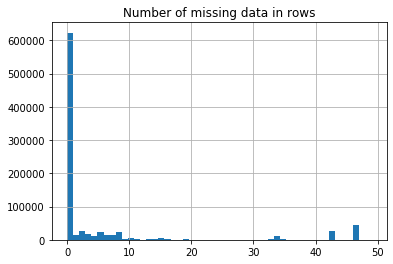

In [72]:
# Plot number of missing data points for each row 
azdias_num_missing_row_data.hist(bins=50)

In [73]:
# Write code to divide the data into two subsets based on the number of missing values in each row.

# Add a column that contains the number of missing values in each row 
azdias_no_outliers2 = azdias_no_outliers.join(azdias_num_missing_row_data)
display(azdias_no_outliers2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Number of missing data in rows
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,5.0,1,4,2,5,4,4,1,...,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN,3
891217,2.0,1,4.0,3,3,3,2,2,3,6,...,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0,4
891218,2.0,2,4.0,2,4,2,5,4,3,1,...,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0,5
891219,1.0,1,3.0,1,5,3,5,5,5,1,...,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0,0


In [74]:
# From the histogram, we can see that there's a breaking point at around the 20 missing data ponts 
# We'll split the dataset there 
azdias_split1 = azdias_no_outliers2[azdias_no_outliers2['Number of missing data in rows'] <= 20]
azdias_split2 = azdias_no_outliers2[azdias_no_outliers2['Number of missing data in rows'] > 20]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129923eb8>]],
      dtype=object)

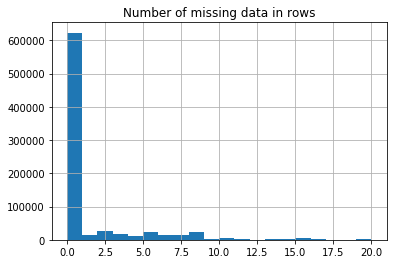

In [75]:
# Display data points with less than 20 values missing
azdias_split1.hist(column='Number of missing data in rows', bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x161b494a8>]],
      dtype=object)

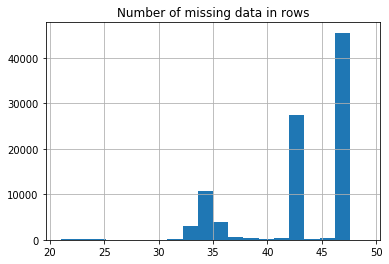

In [76]:
# Display data points with equal to or more than 20 values missing
azdias_split2.hist(column='Number of missing data in rows', bins=20)

In [77]:
# Compare the distribution of values for at least five columns where there are 
# no or few missing values, between the two subsets.

def compare_columns(df1, df2, column):
    '''Plots distribution of values in a specified column from two dataframes'''
    fig, ax = plt.subplots(1, 2)
    sns.countplot(df1[column], ax=ax[0])
    sns.countplot(df2[column], ax=ax[1])
    plt.subplots_adjust(wspace=0.5)
    fig.show()
    return

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


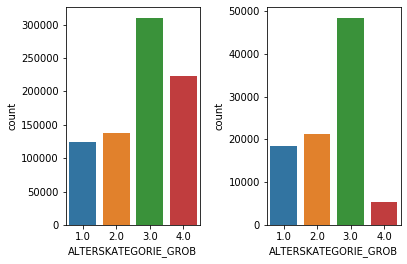

In [78]:
# Distribution 1 (ALTERSKATEGORIE_GROB)
compare_columns(azdias_split1, azdias_split2, 'ALTERSKATEGORIE_GROB')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


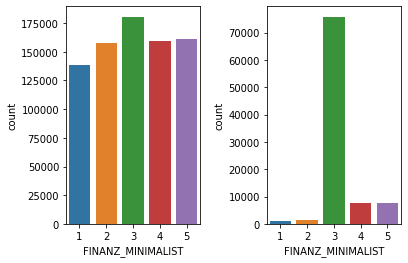

In [79]:
# Distribution 2 (FINANZ_MINIMALIST)
compare_columns(azdias_split1, azdias_split2, 'FINANZ_MINIMALIST')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


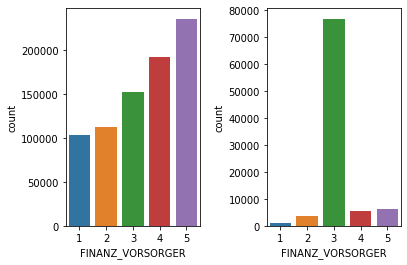

In [80]:
# Distribution 3 (FINANZ_VORSORGER)
compare_columns(azdias_split1, azdias_split2, 'FINANZ_VORSORGER')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


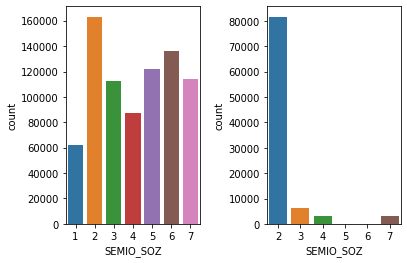

In [81]:
# Distribution 4 (SEMIO_SOZ)
compare_columns(azdias_split1, azdias_split2, 'SEMIO_SOZ')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


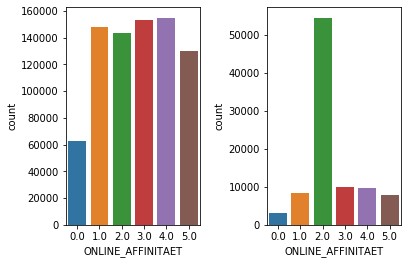

In [82]:
# Distribution 5 (ONLINE_AFFINITAET)
compare_columns(azdias_split1, azdias_split2, 'ONLINE_AFFINITAET')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


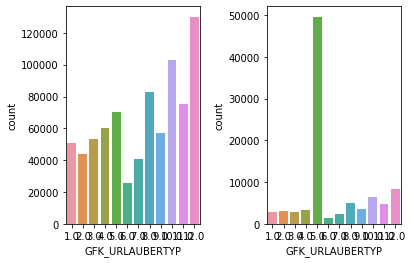

In [83]:
# Distribution 6 (GFK_URLAUBERTYP)
compare_columns(azdias_split1, azdias_split2, 'GFK_URLAUBERTYP')

In [84]:
# Keep rows that contain less or equal to 10 missing values 
azdias_no_outliers3 = azdias_no_outliers2[azdias_no_outliers2['Number of missing data in rows'] <= 10]
display(azdias_no_outliers3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Number of missing data in rows
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,5.0,1,4,2,5,4,4,1,...,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN,3
891217,2.0,1,4.0,3,3,3,2,2,3,6,...,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0,4
891218,2.0,2,4.0,2,4,2,5,4,3,1,...,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0,5
891219,1.0,1,3.0,1,5,3,5,5,5,1,...,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0,0


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)  

The dataset can be divided into 2 prominent subsets: 
1. A dataset with data missing less than or equal to 20 values in a single row
2. A dataset with data missing more than 20 values in a single row 

Above, I analyzed rows on 6 different features with minimal missing values. Interestingly, 5/6 of the features examined were quite different when comparing the two subsets. This potentially hints that these subsets are unique and are still useful to analyze.  

I decided to only keep rows with less or equal to 10 missing values, as any more missing values may create a bias and cause in poor results. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [85]:
display(feat_info_no_outliers)

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


In [86]:
# How many features are there of each data type?
num_each_feature = feat_info_no_outliers.type.value_counts()
display(num_each_feature)

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [87]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

# Section off categorical features
categorical_features = feat_info_no_outliers[feat_info_no_outliers['type'] == 'categorical']
display(categorical_features)

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [88]:
# Display feature data
display(azdias_no_outliers3[categorical_features['attribute']])

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,W,8,8A
2,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,W,4,4C
3,2,2.0,6,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3,1.0,W,2,2A
4,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,W,6,6B
5,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4,1.0,W,8,8C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,2,5.0,1,12.0,0,1.0,1.0,2.0,1.0,1.0,3.0,0.0,1.0,4,8.0,W,7,7A
891217,1,4.0,6,1.0,0,1.0,1.0,1.0,1.0,NaN,NaN,0.0,NaN,6,8.0,W,9,9D
891218,2,4.0,1,10.0,0,NaN,NaN,4.0,2.0,1.0,2.0,0.0,1.0,4,8.0,W,4,4C
891219,1,3.0,1,9.0,0,9.0,5.0,2.0,1.0,1.0,0.0,0.0,2.0,5,8.0,W,9,9D


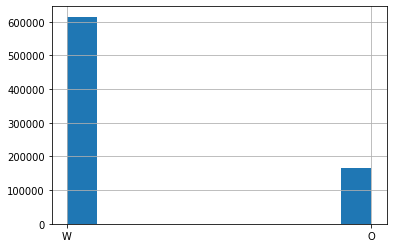

In [89]:
# Visually, we can see that the one binary variable that takes on non-numeric values is 'OST_WEST_KZ'
# We need to re-encode the values as numbers 

# Plotting 'OST_WEST_KZ' to ensure it contains non-numeric values 
azdias_no_outliers3['OST_WEST_KZ'].hist()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


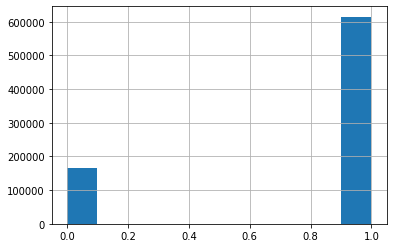

In [90]:
# We'll replace 'O' with 0, and 'W' with 1
azdias_no_outliers3['OST_WEST_KZ'] = azdias_no_outliers3['OST_WEST_KZ'].replace({'O': 0.0, 'W': 1.0})

# Plot again to check changes
azdias_no_outliers3['OST_WEST_KZ'].hist()

In [91]:
# To determine, of the remaining variables, 
# which are binary categoricals and which are multi-level categoricals,
# we'll create a list to keep track of the features that are multi-level categoricals 

multi_level_categorical_features = []
for feature in categorical_features['attribute']:  # Iterate over all categorical features 
    
    # Save list of unique values 
    unique_values = azdias_no_outliers3[feature].unique() 
    
    # Save features that contain more than 2 values 
    if unique_values.size > 2: 
        multi_level_categorical_features.append(feature)
    
    print('Feature:', feature)  # Print feature name 
    display(unique_values)  # Display unique values 
    print()

Feature: ANREDE_KZ


array([2, 1])


Feature: CJT_GESAMTTYP


array([ 5.,  3.,  2.,  4.,  1.,  6., nan])


Feature: FINANZTYP


array([1, 6, 5, 2, 4, 3])


Feature: GFK_URLAUBERTYP


array([10.,  1.,  5., 12.,  9.,  3.,  8., 11.,  4.,  7.,  2.,  6., nan])


Feature: GREEN_AVANTGARDE


array([0, 1])


Feature: LP_FAMILIE_FEIN


array([ 5.,  1., nan, 10.,  2.,  7., 11.,  8.,  4.,  6.,  9.,  3.])


Feature: LP_FAMILIE_GROB


array([ 3.,  1., nan,  5.,  2.,  4.])


Feature: LP_STATUS_FEIN


array([ 2.,  3.,  9.,  4.,  1., 10.,  5.,  8.,  6.,  7., nan])


Feature: LP_STATUS_GROB


array([ 1.,  2.,  4.,  5.,  3., nan])


Feature: NATIONALITAET_KZ


array([ 1.,  3.,  2., nan])


Feature: SHOPPER_TYP


array([ 3.,  2.,  1.,  0., nan])


Feature: SOHO_KZ


array([1., 0.])


Feature: VERS_TYP


array([ 2.,  1., nan])


Feature: ZABEOTYP


array([5, 3, 4, 1, 6, 2])


Feature: GEBAEUDETYP


array([8., 1., 3., 2., 6., 4., 5.])


Feature: OST_WEST_KZ


array([1., 0.])


Feature: CAMEO_DEUG_2015


array(['8', '4', '2', '6', '1', '9', '5', '7', '3', nan], dtype=object)


Feature: CAMEO_DEU_2015


array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C',
       '8B', '7A', '5D', '9E', '9B', '1B', '3D', nan, '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

In [92]:
# Print all multi-level categorical features
print(multi_level_categorical_features)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [93]:
# Re-encode multi-level categorical features 
azdias_multi_categorical = pd.get_dummies(azdias_no_outliers3, columns=multi_level_categorical_features)
print('New one-hot encoded features (along with original features):')
display(azdias_multi_categorical.columns.tolist())
display(azdias_multi_categorical)

New one-hot encoded features (along with original features):


['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,1,4,2,5,4,4,0,3.0,...,0,0,0,0,0,0,0,0,0,0
891217,2.0,1,3,3,3,2,2,3,0,NaN,...,0,0,0,0,0,0,0,0,1,0
891218,2.0,2,2,4,2,5,4,3,0,1.0,...,0,0,0,0,0,0,0,0,0,0
891219,1.0,1,1,5,3,5,5,5,0,1.0,...,0,0,0,0,0,0,0,0,1,0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

There were 3 types of categorical features:  
- Binary Variable
- Binary Categorical
- Multi-level Categorical

For the single binary variable, I replaced 'O' with 0 and 'W' with 1.  
For the binary categorical, it took numeric values, so I kept them as is.  
For the multi-level categorical, I encoded the values using multiple dummy variables.  
I didn't drop any features incase the data was important. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [94]:
# Display mixed-type features
mixed_features = feat_info_no_outliers[feat_info_no_outliers['type'] == 'mixed']
display(mixed_features)

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [95]:
# See which values are unique in each mixed feature

for feature in mixed_features['attribute']:  # Iterate over all mixed features
    unique_values = azdias_multi_categorical[feature].unique()
    
    print('Feature:', feature)
    display(unique_values)
    print()

Feature: LP_LEBENSPHASE_FEIN


array([21.,  3., nan, 32.,  8.,  2.,  5., 10.,  4.,  6., 23., 12., 20.,
        1., 25., 13., 18., 31., 38., 35., 30.,  7., 22., 14., 29., 24.,
       28., 37., 26., 39., 27., 36.,  9., 34., 33., 15., 11., 40., 16.,
       19., 17.])


Feature: LP_LEBENSPHASE_GROB


array([ 6.,  1., nan, 10.,  2.,  3.,  5.,  7., 12., 11.,  9.,  4.,  8.])


Feature: PRAEGENDE_JUGENDJAHRE


array([14., 15.,  8.,  3., 10., 11.,  5.,  9.,  6.,  4., nan,  2.,  1.,
       12., 13.,  7.])


Feature: WOHNLAGE


array([4., 2., 7., 3., 5., 1., 8., 0.])


Feature: CAMEO_INTL_2015


array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', '25', nan, '23', '31', '52', '35', '45', '44', '32'],
      dtype=object)


Feature: PLZ8_BAUMAX


array([ 1.,  2., nan,  4.,  5.,  3.])

In [96]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: 
# - generation by decade
# - movement (mainstream vs. avantgarde)
# - nation (east vs. west) 

# While there aren't enough levels to disentangle east from west, 
# we'll should create two new variables to capture the other two dimensions: 
# - an interval-type variable for decade
# - a binary variable for movement

# We'll copy feature "PRAEGENDE_JUGENDJAHRE" to two new features:
# - PRAEGENDE_JUGENDJAHRE_AM (avantgarde vs. mainstream)
# - PRAEGENDE_JUGENDJAHRE_DC (decade)

azdias_new = azdias_multi_categorical
azdias_new['PRAEGENDE_JUGENDJAHRE_AM'] = azdias_multi_categorical['PRAEGENDE_JUGENDJAHRE']
azdias_new['PRAEGENDE_JUGENDJAHRE_DC'] = azdias_multi_categorical['PRAEGENDE_JUGENDJAHRE']
display(azdias_new.shape)

(780153, 198)

In [97]:
# Encoding PRAEGENDE_JUGENDJAHRE_DC and PRAEGENDE_JUGENDJAHRE_AM

# Define encoding dictionary for PRAEGENDE_JUGENDJAHRE_DC
dict_DC = {1: 40.0,
           2: 40.0, 
           3: 50.0, 
           4: 50.0,
           5: 60.0,
           6: 60.0,
           7: 60.0,
           8: 70.0,
           9: 70.0,
           10: 80.0,
           11: 80.0,
           12: 80.0,
           13: 80.0,
           14: 90.0,
           15: 90.0}

# Replace PRAEGENDE_JUGENDJAHRE_DC with decade values 
azdias_new['PRAEGENDE_JUGENDJAHRE_DC'] = azdias_new['PRAEGENDE_JUGENDJAHRE_DC'].replace(dict_DC)

# Define encoding dictionary for PRAEGENDE_JUGENDJAHRE_AM 
# Encode Mainstream as 0 and Avantgarde as 1
dict_AM = {1: 0.0,
           2: 1.0,
           3: 0.0,
           4: 1.0,
           5: 0.0,
           6: 1.0,
           7: 1.0,
           8: 0.0,
           9: 1.0,
           10: 0.0,
           11: 1.0,
           12: 0.0,
           13: 1.0,
           14: 0.0, 
           15: 1.0}

# Replace PRAEGENDE_JUGENDJAHRE_AM with avantgarde and mainstream values 
azdias_new['PRAEGENDE_JUGENDJAHRE_AM'] = azdias_new['PRAEGENDE_JUGENDJAHRE_AM'].replace(dict_AM)

In [98]:
# Check PRAEGENDE_JUGENDJAHRE_DC
display(azdias_new['PRAEGENDE_JUGENDJAHRE_DC'])

1         90.0
2         90.0
3         70.0
4         70.0
5         50.0
          ... 
891216    90.0
891217    80.0
891218    90.0
891219    90.0
891220    50.0
Name: PRAEGENDE_JUGENDJAHRE_DC, Length: 780153, dtype: float64

In [99]:
# Check PRAEGENDE_JUGENDJAHRE_AM
display(azdias_new['PRAEGENDE_JUGENDJAHRE_AM'])

1         0.0
2         1.0
3         0.0
4         0.0
5         0.0
         ... 
891216    0.0
891217    0.0
891218    0.0
891219    0.0
891220    0.0
Name: PRAEGENDE_JUGENDJAHRE_AM, Length: 780153, dtype: float64

In [100]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# "CAMEO_INTL_2015" combines information on two axes: 
# - wealth
# - life stage

# We'll break up the two-digit codes by their 'tens'-place and 'ones'-place digits 
# into two new ordinal variables (which, for the purposes of this project, is equivalent to 
# just treating them as their raw numeric values) 

# Wealth can be coded as (in the new feature, CAMEO_INTL_2015_WL): 
# - Wealthy Households: 1
# - Prosperous Households: 2
# - Comfortable Households: 3
# - Less Affluent Households: 4
# - Poorer Households: 5

# Life can be coded as (in the new feature, CAMEO_INTL_2015_LS): 
# - Pre-Family: 0
# - Young Couples: 1
# - Families: 2
# - Older Families: 3 
# - Elders: 4

# We'll copy feature "CAMEO_INTL_2015" to two new features:
# - CAMEO_INTL_2015_WL (wealth)
# - CAMEO_INTL_2015_LS (life stage)

azdias_new['CAMEO_INTL_2015_WL'] = azdias_new['CAMEO_INTL_2015']
azdias_new['CAMEO_INTL_2015_LS'] = azdias_new['CAMEO_INTL_2015']

In [101]:
# Creating wealth encodings 
dict_WL = {'11': 1.0,
           '12': 1.0,
           '13': 1.0,
           '14': 1.0,
           '15': 1.0,
           '21': 2.0,
           '22': 2.0,
           '23': 2.0,
           '24': 2.0,
           '25': 2.0,
           '31': 3.0,
           '32': 3.0,
           '33': 3.0,
           '34': 3.0, 
           '35': 3.0,
           '41': 4.0,
           '42': 4.0,
           '43': 4.0,
           '44': 4.0, 
           '45': 4.0,
           '51': 5.0,
           '52': 5.0,
           '53': 5.0,
           '54': 5.0, 
           '55': 5.0}

# Creating wealth encodings
azdias_new['CAMEO_INTL_2015_WL'] = azdias_new['CAMEO_INTL_2015_WL'].replace(dict_WL)

# Creating life stage encodings 
dict_LS = {'11': 1.0,
           '12': 2.0,
           '13': 3.0,
           '14': 4.0,
           '15': 5.0,
           '21': 1.0,
           '22': 2.0,
           '23': 3.0,
           '24': 4.0,
           '25': 5.0,
           '31': 1.0,
           '32': 2.0,
           '33': 3.0,
           '34': 4.0, 
           '35': 5.0,
           '41': 1.0,
           '42': 2.0,
           '43': 3.0,
           '44': 4.0, 
           '45': 5.0,
           '51': 1.0,
           '52': 2.0,
           '53': 3.0,
           '54': 4.0, 
           '55': 5.0}

# Creating life stage encodings 
azdias_new['CAMEO_INTL_2015_LS'] = azdias_new['CAMEO_INTL_2015_LS'].replace(dict_LS)

In [102]:
# Check CAMEO_INTL_2015_WL
display(azdias_new['CAMEO_INTL_2015_WL'])

1         5.0
2         2.0
3         1.0
4         4.0
5         5.0
         ... 
891216    4.0
891217    5.0
891218    2.0
891219    5.0
891220    4.0
Name: CAMEO_INTL_2015_WL, Length: 780153, dtype: float64

In [103]:
# Check CAMEO_INTL_2015_LS
display(azdias_new['CAMEO_INTL_2015_LS'])

1         1.0
2         4.0
3         2.0
4         3.0
5         4.0
         ... 
891216    1.0
891217    1.0
891218    4.0
891219    1.0
891220    3.0
Name: CAMEO_INTL_2015_LS, Length: 780153, dtype: float64

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)


PRAEGENDE_JUGENDJAHRE was re-encoded.
I divided it into two variables:  
- PRAEGENDE_JUGENDJAHRE_DC (Decade)
- PRAEGENDE_JUGENDJAHRE_AM (Avantgarve vs Mainstream)  

The original feature, PRAEGENDE_JUGENDJAHRE, will be dropped. 


CAMEO_INTL_2015 are re-encoded above. 
I divided it into two variables: 
- CAMEO_INTL_2015_WL (Wealth)
- CAMEO_INTL_2015_LS (Life Stage)

The original feature, CAMEO_INTL_2015, will be dropped. 


LP_LEBENSPHASE_FEIN (Life stage, fine scale) and LP_LEBENSPHASE_GROB (Life stage, rough scale) are quite similar. They both contains people's social status (eg. single/couple/family, income, age, homeowners, single parent, etc).  
It would be impossible to generate a feature that could guarantee no NaNs. However, we'll keep this feature because it could be useful in the future. 

WOHNLAGE (Neighborhood quality) will be dropped because a lack of one feature in PCA shouldn't impact our result too much. 

PLZ8_BAUMAX (Most common building type within the PLZ8 region) will be dropped becayse it's impact is more or less full covered by PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_ANTG3, and PLZ8_ANTG4, except for business buildings. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [104]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [105]:
display(azdias_new.columns.tolist())

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 

In [106]:
display(azdias_new.shape)

(780153, 200)

In [107]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_new.drop(['Number of missing data in rows',
                 'PRAEGENDE_JUGENDJAHRE', 
                 'CAMEO_INTL_2015', 
                 'WOHNLAGE', 
                 'PLZ8_BAUMAX'], axis=1, inplace=True)

In [108]:
display(azdias_new.shape)

(780153, 195)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [11]:
def clean_data_general(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # --- PART 1: Convert missing value codes into NaNs ---
    
    # Check how many missing (not unknown) values in azdias
    df_missing_unknown = df.isnull().sum() 
    
    # Step 1: Remove '[' and ']'
    missing_unknown_values_temp = feat_info['missing_or_unknown'].replace(to_replace=['\[', '\]'], value='', regex=True)

    # Step 2: Split values by ',' to create a list of int
    missing_unknown_values = []
    for value in range(len(missing_unknown_values_temp)):
        missing_unknown_values.append(missing_unknown_values_temp[value].split(','))
    
    # Step 3: Convert values to float (only possible from ints, not strings)
    for i in range(len(missing_unknown_values)):  # Iterate over all features 
        for j in range(len(missing_unknown_values[i])):  # Iterate over all missing values for each feature 

            # Don't touch the missing values already in string format 
            if missing_unknown_values[i][j] in ['', 'X', 'XX']:
                pass

            # Convert the ints into floats 
            else: 
                missing_unknown_values[i][j] = float(missing_unknown_values[i][j])
    
    # Step 4: Fill missing values in azdias with NaN using missing_values
    for values in range(len(missing_unknown_values)):  # Iterate over all features

        # Saving column name
        column_name = feat_info.iloc[values]['attribute']

        # Replace all values in the columns (features) of azdias that are in missing values, with NaN
        df[column_name].replace(missing_unknown_values[values], np.nan, inplace=True) 
    
    
    
    
    
    # --- PART 2: Remove selected columns ---
    
    # Step 1: Calculate missing values after replacing necessary values in azdias
    df_missing_unknown_after_update = df.isnull().sum()

    # Step 2: Create dataframe from number of originally missing values and number of updated missing values 
    s1 = pd.Series(df_missing_unknown, name="Initially missing")
    s2 = pd.Series(df_missing_unknown_after_update, name="Missing after update")
    s = pd.concat([s1, s2], axis=1)
    
    # Step 3: Investigate patterns in the amount of missing data in each column.

    # Number of samples 
    num_samples = df.shape[0]

    # Create Dataframe of percentage of missing values after update 
    df_missing_unknown_after_update_dataframe = pd.DataFrame(df_missing_unknown_after_update, 
                                                             columns = ['Percentage of missing values after update'])
    percentage_missing_values = (df_missing_unknown_after_update_dataframe/num_samples)*100
    
    # Step 4: Let's see which features miss more than 10% of data 
    percentage_missing_values_2 = percentage_missing_values[percentage_missing_values['Percentage of missing values after update'] > 10.0]

    # ---------- TEMP 
    # Plot features that are missing more than 10% of data 
    percentage_missing_values_2.transpose().plot(kind='barh', figsize=(9,21))
    
    # Step 5: Drop outliers (features that are missing more than 20% of data)
    outliers = percentage_missing_values[percentage_missing_values['Percentage of missing values after update'] > 20.0]
    outliers = outliers.transpose()
    
    # Step 6: Find indices of outliers

    # Values that contain outlier's features names will be marked as True, otherwise False
    feat_info_outlier_idx = feat_info.isin(outliers.columns.values.tolist()) 
    
    # Step 7: Remove the outlier columns from the dataset (azdias). (You'll perform other data
    # engineering tasks such as re-encoding and imputation later.)
    df_no_outliers = df.drop(outliers, axis=1)
    
    # Step 8: Removing outliers from feat_info 
    # Dropping rows from feat_info where corresponding row of feat_info_idx is equal to True. 
    feat_info_no_outliers = feat_info.drop(feat_info_outlier_idx[feat_info_outlier_idx.attribute == True].index) 
    
    # Step 9: Check columsn without any missing values
    df_no_missing_values = percentage_missing_values[percentage_missing_values['Percentage of missing values after update'] == 0.0]
    
    # Step 10: Group features that have the same number of missing values 
    df_missing_unknown_after_update_dataframe = df_missing_unknown_after_update_dataframe.rename(index=str, columns={'Percentage of missing values after update': 'Number of missing values'})
    
    
    
    
    
    # --- PART 3: Remove selected rows ---
    
    # Step 1: How much data is missing in each row of the dataset?
    df_num_missing_row_data = pd.DataFrame(df_no_outliers.isnull().sum(axis=1), columns=['Number of missing data in rows'])
    
    # Step 2: Write code to divide the data into two subsets based on the number of missing values in each row.

    # Add a column that contains the number of missing values in each row 
    df_no_outliers2 = df_no_outliers.join(df_num_missing_row_data)
    
    # Step 3: From the histogram, we can see that there's a breaking point at around the 20 missing data ponts 
    # We'll split the dataset there 
    df_split1 = df_no_outliers2[df_no_outliers2['Number of missing data in rows'] <= 20]
    df_split2 = df_no_outliers2[df_no_outliers2['Number of missing data in rows'] > 20]
    
    # Step 4: Keep rows that contain less or equal to 10 missing values 
    df_no_outliers3 = df_no_outliers2[df_no_outliers2['Number of missing data in rows'] <= 10]
    
    
    
    
    
    # --- PART 4: Select, re-encode, and engineer column values ---

    # Step 1: How many features are there of each data type?
    num_each_feature = feat_info_no_outliers.type.value_counts()
    
    # Step 2: Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

    # Section off categorical features
    categorical_features = feat_info_no_outliers[feat_info_no_outliers['type'] == 'categorical']
    
    # We'll replace 'O' with 0, and 'W' with 1
    df_no_outliers3['OST_WEST_KZ'] = df_no_outliers3['OST_WEST_KZ'].replace({'O': 0.0, 'W': 1.0})
    
    # To determine, of the remaining variables, 
    # which are binary categoricals and which are multi-level categoricals,
    # we'll create a list to keep track of the features that are multi-level categoricals 
    multi_level_categorical_features = []
    for feature in categorical_features['attribute']:  # Iterate over all categorical features 

        # Save list of unique values 
        unique_values = df_no_outliers3[feature].unique() 

        # Save features that contain more than 2 values 
        if unique_values.size > 2: 
            multi_level_categorical_features.append(feature)
    
    # Re-encode multi-level categorical features 
    df_multi_categorical = pd.get_dummies(df_no_outliers3, columns=multi_level_categorical_features)
    
    # Display mixed-type features
    mixed_features = feat_info_no_outliers[feat_info_no_outliers['type'] == 'mixed']
    
    # See which values are unique in each mixed feature
    for feature in mixed_features['attribute']:  # Iterate over all mixed features
        unique_values = df_multi_categorical[feature].unique()
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

    # "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: 
    # - generation by decade
    # - movement (mainstream vs. avantgarde)
    # - nation (east vs. west) 

    # While there aren't enough levels to disentangle east from west, 
    # we'll should create two new variables to capture the other two dimensions: 
    # - an interval-type variable for decade
    # - a binary variable for movement

    # We'll copy feature "PRAEGENDE_JUGENDJAHRE" to two new features:
    # - PRAEGENDE_JUGENDJAHRE_AM (avantgarde vs. mainstream)
    # - PRAEGENDE_JUGENDJAHRE_DC (decade)

    df_new = df_multi_categorical
    df_new['PRAEGENDE_JUGENDJAHRE_AM'] = df_multi_categorical['PRAEGENDE_JUGENDJAHRE']
    df_new['PRAEGENDE_JUGENDJAHRE_DC'] = df_multi_categorical['PRAEGENDE_JUGENDJAHRE']

    # Encoding PRAEGENDE_JUGENDJAHRE_DC and PRAEGENDE_JUGENDJAHRE_AM

    # Define encoding dictionary for PRAEGENDE_JUGENDJAHRE_DC
    dict_DC = {1: 40.0,
               2: 40.0, 
               3: 50.0, 
               4: 50.0,
               5: 60.0,
               6: 60.0,
               7: 60.0,
               8: 70.0,
               9: 70.0,
               10: 80.0,
               11: 80.0,
               12: 80.0,
               13: 80.0,
               14: 90.0,
               15: 90.0}

    # Replace PRAEGENDE_JUGENDJAHRE_DC with decade values 
    df_new['PRAEGENDE_JUGENDJAHRE_DC'] = df_new['PRAEGENDE_JUGENDJAHRE_DC'].replace(dict_DC)

    # Define encoding dictionary for PRAEGENDE_JUGENDJAHRE_AM 
    # Encode Mainstream as 0 and Avantgarde as 1
    dict_AM = {1: 0.0,
               2: 1.0,
               3: 0.0,
               4: 1.0,
               5: 0.0,
               6: 1.0,
               7: 1.0,
               8: 0.0,
               9: 1.0,
               10: 0.0,
               11: 1.0,
               12: 0.0,
               13: 1.0,
               14: 0.0, 
               15: 1.0}

    # Replace PRAEGENDE_JUGENDJAHRE_AM with avantgarde and mainstream values 
    df_new['PRAEGENDE_JUGENDJAHRE_AM'] = df_new['PRAEGENDE_JUGENDJAHRE_AM'].replace(dict_AM)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    # "CAMEO_INTL_2015" combines information on two axes: 
    # - wealth
    # - life stage

    # We'll break up the two-digit codes by their 'tens'-place and 'ones'-place digits 
    # into two new ordinal variables (which, for the purposes of this project, is equivalent to 
    # just treating them as their raw numeric values) 

    # Wealth can be coded as (in the new feature, CAMEO_INTL_2015_WL): 
    # - Wealthy Households: 1
    # - Prosperous Households: 2
    # - Comfortable Households: 3
    # - Less Affluent Households: 4
    # - Poorer Households: 5

    # Life can be coded as (in the new feature, CAMEO_INTL_2015_LS): 
    # - Pre-Family: 0
    # - Young Couples: 1
    # - Families: 2
    # - Older Families: 3 
    # - Elders: 4

    # We'll copy feature "CAMEO_INTL_2015" to two new features:
    # - CAMEO_INTL_2015_WL (wealth)
    # - CAMEO_INTL_2015_LS (life stage)

    df_new['CAMEO_INTL_2015_WL'] = df_new['CAMEO_INTL_2015']
    df_new['CAMEO_INTL_2015_LS'] = df_new['CAMEO_INTL_2015']

    # Creating wealth encodings 
    dict_WL = {'11': 1.0,
               '12': 1.0,
               '13': 1.0,
               '14': 1.0,
               '15': 1.0,
               '21': 2.0,
               '22': 2.0,
               '23': 2.0,
               '24': 2.0,
               '25': 2.0,
               '31': 3.0,
               '32': 3.0,
               '33': 3.0,
               '34': 3.0, 
               '35': 3.0,
               '41': 4.0,
               '42': 4.0,
               '43': 4.0,
               '44': 4.0, 
               '45': 4.0,
               '51': 5.0,
               '52': 5.0,
               '53': 5.0,
               '54': 5.0, 
               '55': 5.0}

    # Creating wealth encodings
    df_new['CAMEO_INTL_2015_WL'] = df_new['CAMEO_INTL_2015_WL'].replace(dict_WL)

    # Creating life stage encodings 
    dict_LS = {'11': 1.0,
               '12': 2.0,
               '13': 3.0,
               '14': 4.0,
               '15': 5.0,
               '21': 1.0,
               '22': 2.0,
               '23': 3.0,
               '24': 4.0,
               '25': 5.0,
               '31': 1.0,
               '32': 2.0,
               '33': 3.0,
               '34': 4.0, 
               '35': 5.0,
               '41': 1.0,
               '42': 2.0,
               '43': 3.0,
               '44': 4.0, 
               '45': 5.0,
               '51': 1.0,
               '52': 2.0,
               '53': 3.0,
               '54': 4.0, 
               '55': 5.0}

    # Creating life stage encodings 
    df_new['CAMEO_INTL_2015_LS'] = df_new['CAMEO_INTL_2015_LS'].replace(dict_LS)
    
    # Do whatever you need to in order to ensure that the dataframe only contains
    # the columns that should be passed to the algorithm functions.
    df_new.drop(['Number of missing data in rows',
                 'PRAEGENDE_JUGENDJAHRE', 
                 'CAMEO_INTL_2015', 
                 'WOHNLAGE', 
                 'PLZ8_BAUMAX'], axis=1, inplace=True)
    
    
    
    
    
    # --- PART 5: Return the cleaned dataframe ---
    return df_new

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_WL,CAMEO_INTL_2015_LS
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0.0,90.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,1.0,90.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0.0,70.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0.0,70.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0.0,50.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,1,4,2,5,4,4,0,3.0,...,0,0,0,0,0,0,0.0,90.0,4.0,1.0
891217,2.0,1,3,3,3,2,2,3,0,NaN,...,0,0,0,0,1,0,0.0,80.0,5.0,1.0
891218,2.0,2,2,4,2,5,4,3,0,1.0,...,0,0,0,0,0,0,0.0,90.0,2.0,4.0
891219,1.0,1,1,5,3,5,5,5,0,1.0,...,0,0,0,0,1,0,0.0,90.0,5.0,1.0


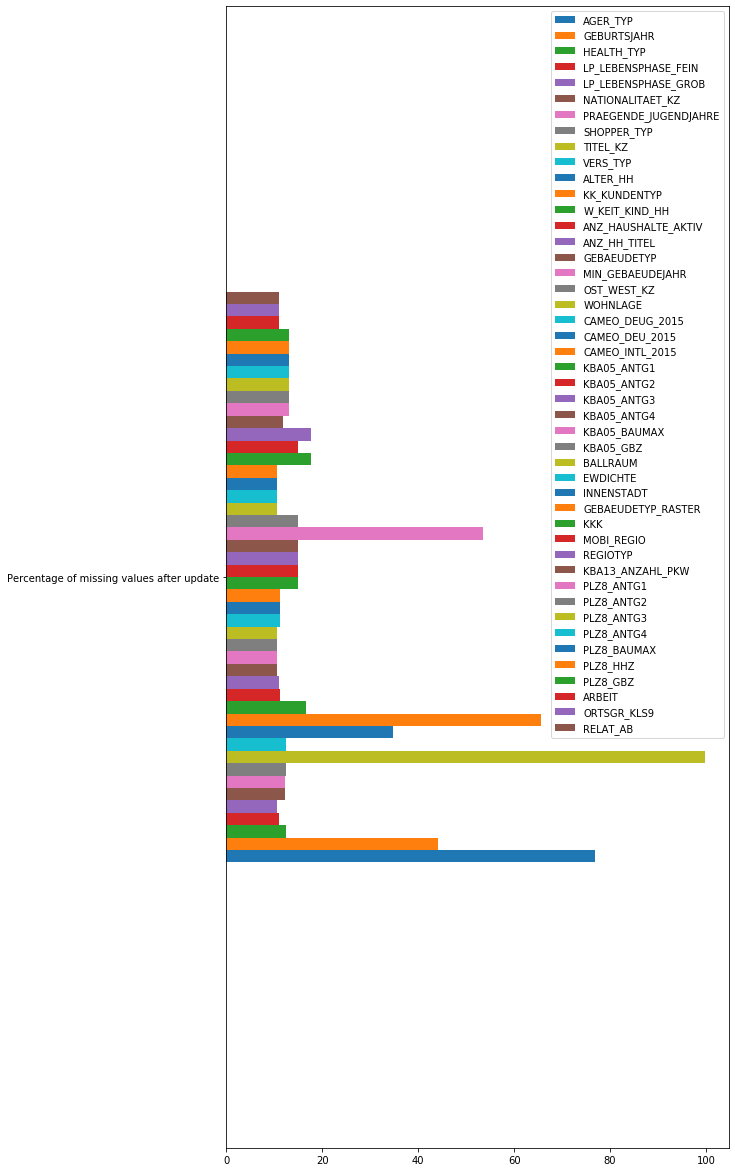

In [12]:
azdias_cleaned = clean_data_general(azdias)
display(azdias_cleaned)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [13]:
# Clean the dataset of all NaN values 
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(azdias_cleaned)
azdias_cleaned_imputed = pd.DataFrame(imputer.transform(azdias_cleaned))
azdias_cleaned_imputed.columns = azdias_cleaned.columns
azdias_cleaned_imputed.index = azdias_cleaned.index
display(azdias_cleaned_imputed)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_WL,CAMEO_INTL_2015_LS
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,90.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2.0,1.0,4.0,2.0,5.0,4.0,4.0,0.0,3.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,4.0,1.0
891217,2.0,1.0,3.0,3.0,3.0,2.0,2.0,3.0,0.0,2.20384,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,80.0,5.0,1.0
891218,2.0,2.0,2.0,4.0,2.0,5.0,4.0,3.0,0.0,1.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,2.0,4.0
891219,1.0,1.0,1.0,5.0,3.0,5.0,5.0,5.0,0.0,1.00000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,90.0,5.0,1.0


In [14]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_cleaned_imputed_scaled = pd.DataFrame(scaler.fit_transform(azdias_cleaned_imputed))
azdias_cleaned_imputed_scaled.columns = azdias_cleaned_imputed.columns
azdias_cleaned_imputed_scaled.index = azdias_cleaned_imputed.index
display(azdias_cleaned_imputed_scaled)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_WL,CAMEO_INTL_2015_LS
1,-1.767099,0.958395,-1.488140,1.539080,-1.045251,1.467273,0.980071,1.326876,-0.531199,1.078455,...,-0.151267,-0.163813,-0.191144,-0.181397,-0.194377,-0.08919,-0.552603,1.169476,1.180325,-1.260258
2,0.198771,0.958395,-1.488140,0.866538,-1.771610,-0.569041,0.262544,1.326876,1.882535,1.078455,...,-0.151267,-0.163813,-0.191144,-0.181397,-0.194377,-0.08919,1.873182,1.169476,-0.871579,0.760774
3,1.181706,0.958395,0.688928,-0.478545,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.276116,...,-0.151267,-0.163813,-0.191144,-0.181397,-0.194377,-0.08919,-0.552603,-0.225811,-1.555547,-0.586581
4,0.198771,-1.043411,0.688928,0.193996,0.407468,-1.247812,0.262544,-0.817895,-0.531199,1.078455,...,-0.151267,-0.163813,-0.191144,-0.181397,-0.194377,-0.08919,-0.552603,-0.225811,0.496357,0.087097
5,-1.767099,0.958395,-0.036761,-1.151087,1.133828,-0.569041,-0.454983,1.326876,-0.531199,1.078455,...,-0.151267,-0.163813,-0.191144,-0.181397,-0.194377,-0.08919,-0.552603,-1.621097,1.180325,0.760774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,0.198771,0.958395,-1.488140,0.866538,-1.045251,1.467273,0.980071,0.611953,-0.531199,1.078455,...,-0.151267,-0.163813,-0.191144,-0.181397,-0.194377,-0.08919,-0.552603,1.169476,0.496357,-1.260258
891217,-0.784164,-1.043411,-0.036761,0.193996,-0.318891,-0.569041,-0.454983,-0.102971,-0.531199,0.000000,...,-0.151267,-0.163813,-0.191144,-0.181397,5.144636,-0.08919,-0.552603,0.471833,1.180325,-1.260258
891218,-0.784164,0.958395,-0.762450,0.866538,-1.045251,1.467273,0.980071,-0.102971,-0.531199,-1.630686,...,-0.151267,-0.163813,-0.191144,-0.181397,-0.194377,-0.08919,-0.552603,1.169476,-0.871579,0.760774
891219,-1.767099,-1.043411,-1.488140,1.539080,-0.318891,1.467273,1.697599,1.326876,-0.531199,-1.630686,...,-0.151267,-0.163813,-0.191144,-0.181397,5.144636,-0.08919,-0.552603,1.169476,1.180325,-1.260258


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I decided to replace the NaNs with the mean along its respective feature/column, with the condition that a particular row isn't missing more than 10 values, since I can use 780153/891221, which is ~87.54% of the dataset.  
Keeping a large sample size could be definitive in my predictions, so I tried to keep as many of them as possible.  

I then applied a defaulit Standard Scaler to the dataset after dropping designated columns, rows, and having imputting missing values. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [15]:
def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)


def plot_component(pca, comp):
    '''
    Plots an image associated with each component to understand how the weighting 
    of the components 
    INPUT: 
          pca - pca object created from PCA in sklearn
          comp - int - the component you want to see starting at 0
    OUTPUT
          None
    '''
    if comp <= len(pca.components_):
        mat_data = np.asmatrix(pca.components_[comp]).reshape(28,28)  #reshape images
        plt.imshow(mat_data); #plot the data
        plt.xticks([]) #removes numbered labels on x-axis
        plt.yticks([]) #removes numbered labels on y-axis   
    else:
        print('That is not the right input, please read the docstring before continuing.')
    
    
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [16]:
# Apply PCA to the data 
pca = PCA()
azdias_pca = pca.fit_transform(azdias_cleaned_imputed_scaled)
display(pd.DataFrame(azdias_pca))

,0,1,2,3,4,5,6,7,8,9,...,185,186,187,188,189,190,191,192,193,194
0,4.599885,-4.056946,-3.067894,1.772478,0.535579,1.652068,-0.447421,-0.129040,-0.367269,2.445937,...,-2.893707e-14,-4.949556e-14,-6.538870e-14,-2.145698e-14,-1.571459e-14,8.665314e-14,5.789019e-14,5.856723e-14,-3.046113e-14,-1.122598e-16
1,-0.124242,-0.520120,-3.346094,-0.778882,-4.211894,1.581099,-1.090391,-0.279967,-1.067084,-0.994139,...,1.131244e-14,3.087658e-14,-1.384455e-14,3.898706e-14,5.512162e-14,4.012186e-14,4.334128e-14,2.233515e-14,-1.970750e-14,3.238392e-17
2,-4.758547,1.733518,-1.410019,-2.067693,0.829946,-2.210408,1.229327,-0.746098,0.365304,1.134557,...,-2.170077e-14,6.903593e-15,-1.281239e-14,5.270846e-16,-1.423267e-14,1.663674e-14,5.099257e-15,1.771533e-14,-1.241701e-14,-3.435094e-16
3,-0.665427,0.126772,3.165043,2.853971,2.633616,2.041669,-3.333264,1.491899,-2.668058,-3.610706,...,2.779898e-14,1.244846e-13,2.351947e-14,1.594578e-15,-3.206936e-14,2.170532e-14,-6.278401e-14,1.118143e-14,1.152983e-14,-5.395417e-17
4,-0.188380,-0.561606,-1.223674,-3.978260,-0.285055,2.342363,-2.553855,-0.914439,-0.820194,-0.186004,...,-2.224561e-14,-1.877476e-14,-4.135840e-15,-6.643476e-14,5.330949e-14,1.097068e-14,2.437977e-14,2.466091e-14,-8.888959e-15,-6.623471e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780148,1.414239,-2.042053,-4.334078,-2.000451,-0.561482,-0.210476,0.437481,-0.800305,0.295152,0.138164,...,-1.454568e-16,1.542357e-16,-2.349907e-17,4.820616e-18,1.925381e-16,-6.381077e-17,-2.217080e-16,8.253453e-17,-4.882259e-17,7.835789e-18
780149,5.661800,1.594388,1.621119,-0.540817,0.391816,-1.759867,1.054762,-1.913477,-0.822413,0.666375,...,-1.285470e-16,-3.097584e-18,-2.716210e-16,-5.312837e-17,1.794543e-16,1.483263e-16,-4.128514e-16,-8.265877e-17,-1.316560e-16,5.193205e-18
780150,-0.791690,-3.926976,-3.471983,-2.662309,-0.174364,2.749654,-0.891047,-0.153185,-0.100752,0.487199,...,9.581223e-17,-1.631930e-16,-3.971105e-16,3.083814e-16,-1.916625e-16,-2.695853e-17,1.585713e-16,-1.555200e-16,5.274377e-17,6.036765e-18
780151,5.684100,-4.829620,2.827904,2.428476,3.354995,-0.116175,-2.077975,-2.036966,1.546346,-0.967790,...,2.765371e-17,4.292038e-17,-2.643012e-17,2.398511e-16,-1.697637e-16,1.508409e-16,3.593996e-17,-6.089607e-17,3.435537e-17,-5.599585e-18


,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_WL,CAMEO_INTL_2015_LS
Dimension 1,0.0813,-0.0781,0.0141,-0.1860,0.1084,-0.0786,0.0502,0.0480,0.1483,-0.1058,...,0.0255,0.0365,0.0557,0.0567,0.0562,0.0172,-0.1035,0.0673,0.1818,-0.1076
Dimension 2,0.0573,0.2348,0.0380,0.0944,-0.2295,0.2204,-0.2046,-0.2150,0.0799,-0.0051,...,0.0339,-0.0082,0.0003,0.0045,0.0104,0.0380,-0.0042,-0.2391,0.0503,0.0152
Dimension 3,0.0350,0.0155,-0.3447,0.1288,-0.0550,0.0467,-0.1535,-0.0459,-0.0619,0.0771,...,0.0003,-0.0037,0.0130,0.0258,0.0122,-0.0013,0.0748,-0.0497,0.0189,-0.0159
Dimension 4,0.0293,0.0014,0.0718,-0.0099,-0.0005,0.0056,-0.0447,0.0096,0.0019,0.1824,...,-0.0001,0.0210,0.0096,0.0145,0.0104,0.0063,0.1831,0.0115,0.0121,-0.0086
Dimension 5,0.0237,0.0519,-0.0604,0.0183,-0.0257,0.0393,0.0497,-0.1083,0.0139,-0.2583,...,0.0333,0.0518,0.0318,0.0131,0.0206,-0.0019,-0.2599,-0.0357,0.1360,-0.0688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dimension 191,0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,...,-0.0666,-0.0534,-0.0594,-0.0565,-0.0603,-0.0331,-0.0000,-0.0000,0.0126,0.0192
Dimension 192,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,...,-0.1547,0.0161,0.0371,0.0353,0.0376,-0.0176,-0.0000,-0.0000,-0.0623,0.1483
Dimension 193,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,...,0.0426,-0.0107,-0.0106,-0.0101,-0.0107,-0.0084,-0.0000,0.0000,-0.0834,0.0140
Dimension 194,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,...,-0.0230,0.0231,0.0340,0.0324,0.0346,0.0022,0.0000,-0.0000,0.0690,0.0591


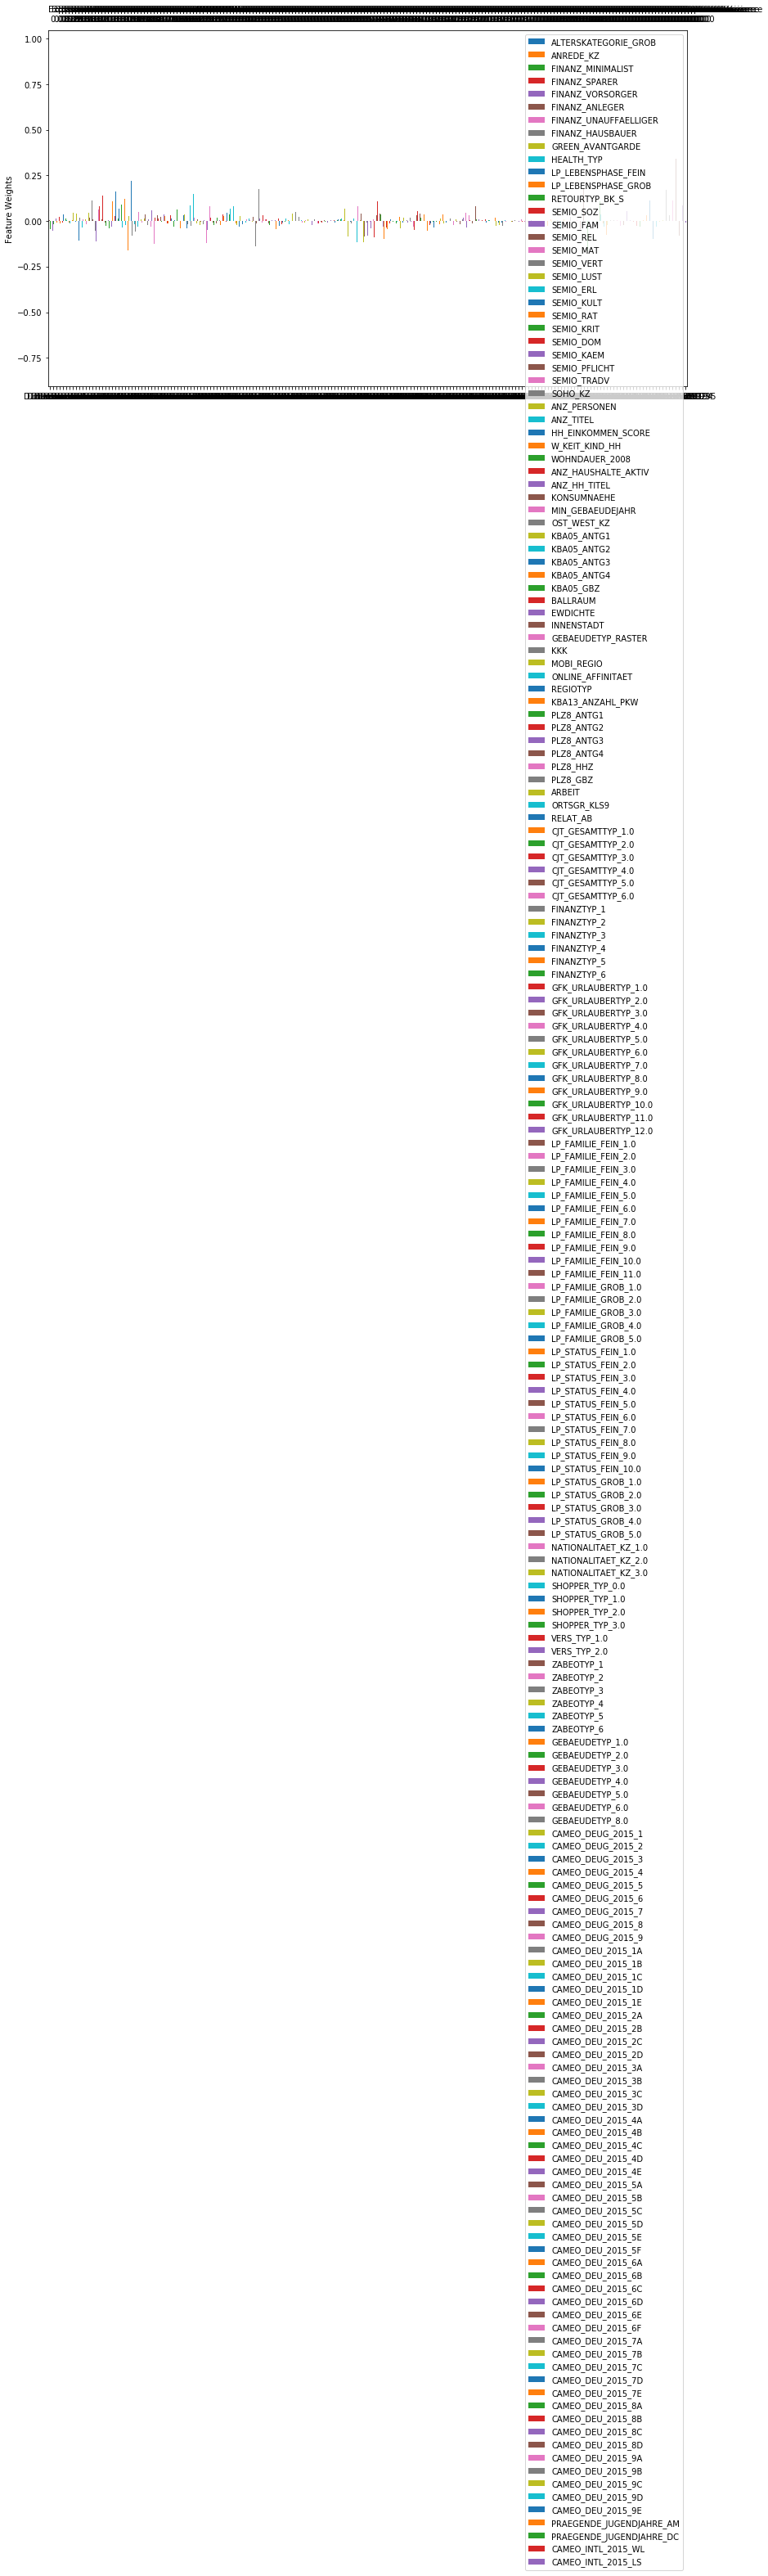

In [17]:
# Investigate the variance accounted for by each principal component.
pca_output = pca_results(azdias_cleaned_imputed_scaled, pca)
display(pca_output)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,4.599987,-4.057391,-3.071360,1.759191,0.543608,1.430703,-0.449228,0.114145,-0.695780,2.281965,2.313311,-1.101687,1.378469,-2.285820,0.957562,-0.725888,1.781670,-0.409569,5.190213,-0.339000
1,-0.124266,-0.520183,-3.348144,-0.774826,-4.197956,1.560036,-1.135392,-0.368215,-0.977091,-0.899780,0.489160,-0.803688,0.840596,0.543213,-0.725741,3.095518,-0.519149,-0.916456,-1.574930,-0.984109
2,-4.758460,1.732730,-1.410685,-2.061179,0.816539,-2.201024,1.283539,-0.812840,0.625605,1.160472,-1.648704,-1.335228,-0.231140,-0.360246,0.332839,-1.458639,2.325692,-0.427563,-0.315816,1.182117
3,-0.665445,0.127305,3.164863,2.857593,2.635213,1.998131,-3.400082,1.292974,-2.686917,-3.424895,0.090005,2.088883,-0.478658,1.955928,0.970049,-0.248110,0.987818,0.043746,-0.707125,1.173515
4,-0.188462,-0.560401,-1.216747,-3.995267,-0.243182,2.203982,-2.514914,-0.991666,-0.899641,-0.126697,0.817413,0.714565,1.127597,-2.470080,-1.430178,-1.497004,0.011120,-1.596661,-0.108506,0.146125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780148,1.414300,-2.040739,-4.331451,-2.002788,-0.584658,-0.001206,0.338047,-0.782572,0.191233,0.199213,-1.109269,-2.301021,2.095163,1.146502,1.932273,-1.339822,-1.824554,3.066523,1.279988,1.838223
780149,5.661862,1.594338,1.620804,-0.537206,0.387486,-1.720236,1.120537,-2.067140,-0.747245,0.582703,-0.057867,-0.120715,-1.057017,1.414642,-0.016247,-0.099021,-0.920522,-2.297447,0.163223,-0.890314
780150,-0.791660,-3.926143,-3.472235,-2.663761,-0.147371,2.652945,-0.817648,-0.209260,-0.251930,0.625566,1.016947,-0.893390,1.295403,0.551480,0.041888,2.831024,-0.844896,-1.694140,-1.263802,-0.047464
780151,5.684248,-4.830685,2.825666,2.427922,3.325507,-0.111228,-2.028727,-1.902799,1.673121,-0.880666,0.030364,-0.360901,1.303192,2.869411,0.201445,0.918716,-0.046090,1.931272,0.149191,0.172999


,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_WL,CAMEO_INTL_2015_LS
Dimension 1,0.0813,-0.0781,0.0141,-0.1860,0.1084,-0.0786,0.0502,0.0480,0.1483,-0.1058,...,0.0255,0.0365,0.0557,0.0567,0.0562,0.0172,-0.1035,0.0673,0.1818,-0.1076
Dimension 2,0.0573,0.2348,0.0380,0.0944,-0.2295,0.2204,-0.2046,-0.2150,0.0799,-0.0051,...,0.0339,-0.0082,0.0003,0.0045,0.0104,0.0380,-0.0042,-0.2391,0.0503,0.0152
Dimension 3,0.0350,0.0154,-0.3447,0.1289,-0.0551,0.0468,-0.1534,-0.0460,-0.0619,0.0771,...,0.0003,-0.0038,0.0130,0.0259,0.0121,-0.0013,0.0748,-0.0498,0.0189,-0.0159
Dimension 4,0.0293,0.0015,0.0717,-0.0100,-0.0004,0.0055,-0.0447,0.0096,0.0018,0.1823,...,-0.0001,0.0211,0.0097,0.0144,0.0105,0.0063,0.1829,0.0116,0.0119,-0.0085
Dimension 5,0.0237,0.0518,-0.0603,0.0185,-0.0260,0.0394,0.0496,-0.1087,0.0141,-0.2581,...,0.0336,0.0520,0.0326,0.0132,0.0201,-0.0014,-0.2598,-0.0359,0.1365,-0.0685
Dimension 6,0.0158,0.0063,0.0066,-0.1272,0.0072,0.0321,0.0171,0.0242,0.1938,-0.0304,...,0.0052,-0.0423,-0.0783,-0.0573,-0.0651,0.0251,-0.0255,-0.0323,0.0066,0.0595
Dimension 7,0.0148,0.0143,0.0051,0.0736,-0.0169,-0.0405,-0.0161,-0.0279,-0.1227,-0.0531,...,-0.0647,0.0022,0.0541,0.0611,0.0267,0.0684,-0.0546,0.0322,-0.0602,-0.0809
Dimension 8,0.0133,0.0039,-0.0075,0.0389,-0.0345,-0.0382,-0.0286,-0.0357,-0.0328,-0.0069,...,0.0743,-0.0806,-0.0732,-0.0888,-0.1183,-0.0422,-0.0137,0.0174,0.0134,0.1602
Dimension 9,0.0130,-0.0335,0.0477,-0.0458,0.0233,-0.0666,0.0934,-0.0478,0.1196,0.0138,...,0.0716,0.0195,0.0590,0.0283,0.0114,0.0533,0.0167,-0.0196,-0.0652,0.1785
Dimension 10,0.0126,0.0226,0.0117,-0.0361,-0.0104,0.0729,-0.0254,0.0335,0.0535,-0.0451,...,-0.0351,0.0520,0.0040,0.0348,0.0565,0.0434,-0.0396,-0.0502,-0.0233,-0.0852


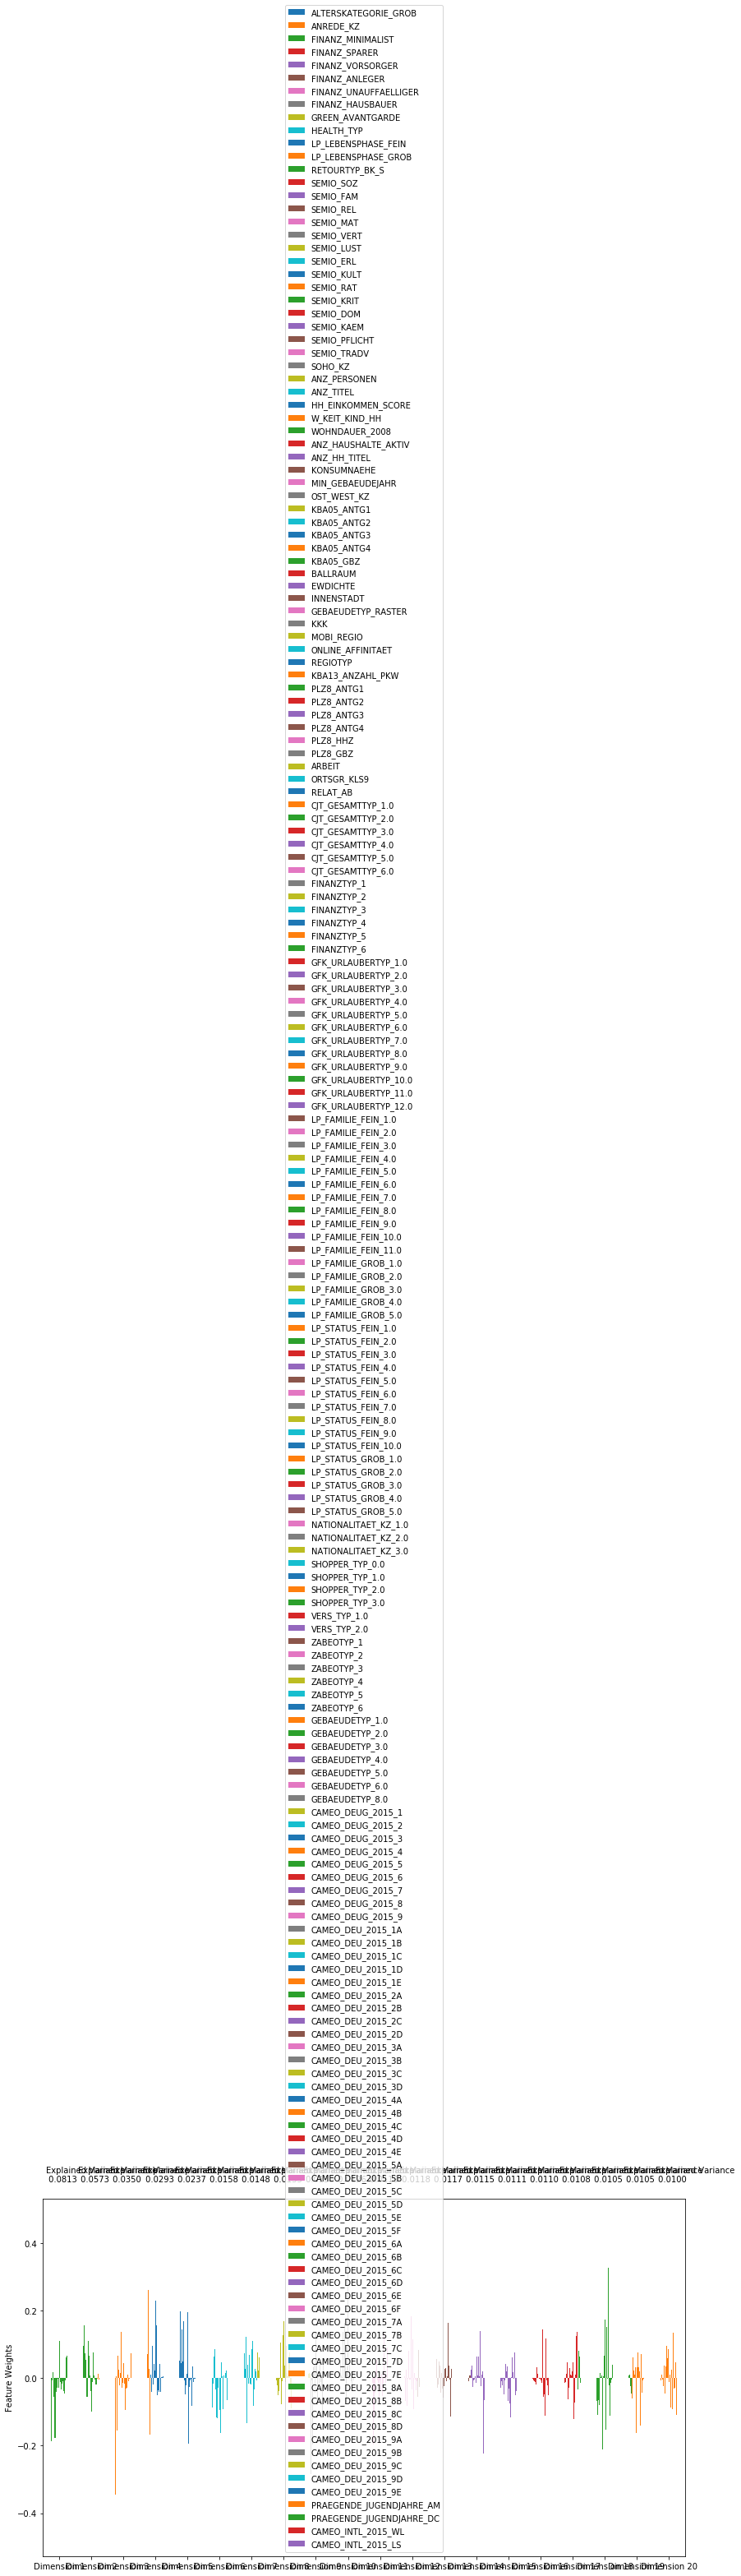

In [18]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_20 = PCA(20)
azdias_pca_20 = pca_20.fit_transform(azdias_cleaned_imputed_scaled)
pca_20_output = pca_results(azdias_cleaned_imputed_scaled, pca_20)

display(pd.DataFrame(azdias_pca_20))
display(pca_20_output)

Cumulative variance for PCA with 20 components: 0.4069995071912997


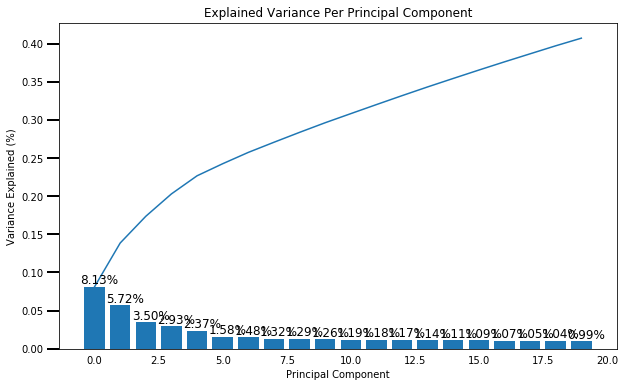

In [19]:
# Check cumulative variance for pca_20
print('Cumulative variance for PCA with 20 components:', pca_20.explained_variance_ratio_.sum())
scree_plot(pca_20)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Initially, I applied PCA with the default number of components, 195 (one component for each feature), to find the maximal variance in the data.  
Checking the ratio of the explained variance using a scree plot, the explained variance from the 21st component onwards is less than 1%. Therefore, I've decided to limit the number of components to use for PCA to 20, which gives ~41% variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [26]:
# Check principal components
components_df = pd.DataFrame(pca_20.components_)
components_df.columns = azdias_cleaned_imputed_scaled.columns
display(components_df)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_WL,CAMEO_INTL_2015_LS
0,-0.078115,0.014129,-0.186034,0.108398,-0.078636,0.050171,0.048009,0.148268,-0.105784,0.024145,...,0.025479,0.036467,0.055741,0.056718,0.056249,0.017220,-0.103521,0.067314,0.181847,-0.107597
1,0.234785,0.037985,0.094399,-0.229486,0.220379,-0.204570,-0.215023,0.079891,-0.005144,-0.051900,...,0.033874,-0.008240,0.000344,0.004498,0.010379,0.037994,-0.004227,-0.239093,0.050326,0.015243
2,0.015448,-0.344711,0.128861,-0.055059,0.046777,-0.153436,-0.046012,-0.061852,0.077115,-0.005050,...,0.000271,-0.003762,0.012997,0.025856,0.012124,-0.001333,0.074818,-0.049788,0.018913,-0.015928
3,0.001529,0.071707,-0.010000,-0.000395,0.005510,-0.044717,0.009620,0.001812,0.182287,-0.011645,...,-0.000085,0.021113,0.009684,0.014441,0.010519,0.006260,0.182913,0.011631,0.011914,-0.008499
4,0.051771,-0.060348,0.018540,-0.025953,0.039388,0.049627,-0.108705,0.014051,-0.258098,-0.001458,...,0.033634,0.052012,0.032649,0.013186,0.020099,-0.001439,-0.259751,-0.035921,0.136480,-0.068499
5,0.006346,0.006618,-0.127233,0.007201,0.032104,0.017058,0.024204,0.193759,-0.030394,-0.086695,...,0.005219,-0.042348,-0.078336,-0.057341,-0.065064,0.025070,-0.025487,-0.032263,0.006614,0.059494
6,0.014343,0.005099,0.073599,-0.016922,-0.040546,-0.016087,-0.027860,-0.122716,-0.053137,0.073528,...,-0.064749,0.002248,0.054087,0.061062,0.026707,0.068426,-0.054590,0.032247,-0.060238,-0.080896
7,0.003859,-0.007542,0.038919,-0.034538,-0.038226,-0.028596,-0.035713,-0.032774,-0.006943,0.005147,...,0.074286,-0.080563,-0.073187,-0.088779,-0.118308,-0.042172,-0.013696,0.017354,0.013369,0.160168
8,-0.033460,0.047741,-0.045816,0.023338,-0.066617,0.093390,-0.047814,0.119643,0.013784,-0.128649,...,0.071595,0.019457,0.059037,0.028324,0.011449,0.053318,0.016734,-0.019638,-0.065168,0.178450
9,0.022574,0.011665,-0.036119,-0.010364,0.072939,-0.025413,0.033503,0.053483,-0.045112,-0.107636,...,-0.035127,0.052004,0.003964,0.034838,0.056527,0.043445,-0.039630,-0.050222,-0.023330,-0.085152


In [27]:
# Function to map each feature weight to their corresponding feature name, 
# then sort the features according to weight
def principal_component_feat(index, components_df):
    sorted_components_df = components_df.sort_values(components_df.index[index], axis=1)
    return sorted_components_df.iloc[[index]]

In [28]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
display(principal_component_feat(0, components_df))

,MOBI_REGIO,KBA05_ANTG1,FINANZ_MINIMALIST,KBA05_GBZ,PLZ8_ANTG1,LP_LEBENSPHASE_FEIN,KONSUMNAEHE,LP_LEBENSPHASE_GROB,PLZ8_GBZ,INNENSTADT,...,KBA05_ANTG4,LP_STATUS_FEIN_1.0,FINANZ_HAUSBAUER,EWDICHTE,ORTSGR_KLS9,PLZ8_ANTG4,PLZ8_ANTG3,CAMEO_INTL_2015_WL,HH_EINKOMMEN_SCORE,LP_STATUS_GROB_1.0
0,-0.201023,-0.188359,-0.186034,-0.178142,-0.178034,-0.145632,-0.1328,-0.132045,-0.129519,-0.123034,...,0.124338,0.126291,0.148268,0.14842,0.149594,0.171291,0.177267,0.181847,0.18464,0.191704


In [29]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
display(principal_component_feat(1, components_df))

,PRAEGENDE_JUGENDJAHRE_DC,FINANZ_SPARER,SEMIO_REL,FINANZ_UNAUFFAELLIGER,SEMIO_TRADV,SEMIO_PFLICHT,FINANZ_ANLEGER,SEMIO_RAT,SEMIO_KULT,ONLINE_AFFINITAET,...,FINANZ_MINIMALIST,FINANZTYP_5,CJT_GESAMTTYP_2.0,W_KEIT_KIND_HH,RETOURTYP_BK_S,SEMIO_LUST,SEMIO_ERL,ZABEOTYP_3,FINANZ_VORSORGER,ALTERSKATEGORIE_GROB
1,-0.239093,-0.229486,-0.216571,-0.215023,-0.2089,-0.208349,-0.20457,-0.170545,-0.166267,-0.162228,...,0.094399,0.096316,0.10964,0.130376,0.155682,0.163437,0.180792,0.199726,0.220379,0.234785


In [30]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
display(principal_component_feat(2, components_df))

,ANREDE_KZ,SEMIO_KAEM,SEMIO_DOM,SEMIO_KRIT,SEMIO_ERL,SEMIO_RAT,FINANZ_ANLEGER,FINANZTYP_1,SHOPPER_TYP_2.0,LP_STATUS_FEIN_2.0,...,SEMIO_MAT,SEMIO_REL,ZABEOTYP_1,SHOPPER_TYP_0.0,FINANZ_MINIMALIST,FINANZTYP_5,SEMIO_KULT,SEMIO_SOZ,SEMIO_FAM,SEMIO_VERT
2,-0.344711,-0.314345,-0.281878,-0.265073,-0.206867,-0.154463,-0.153436,-0.100091,-0.093531,-0.079978,...,0.087033,0.112965,0.116696,0.123784,0.128861,0.136318,0.249749,0.257556,0.259679,0.31894


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

##### Principal Component 1:
Most noteworthy negative features:  
- MOBI_REGIO (Movement patterns)
- KBA05_ANTG1 (Number of 1-2 family houses in the microcell)
- FINANZ_MINIMALIST (Financial typology, low financial interest)

Most noteworthy positive features:
- LP_STATUS_GROB_1.0 (Social status, rough scale)
- HH_EINKOMMEN_SCORE (Estimated household net income)
- CAMEO_INTL_2015_WL (Wealth of household)

It appears that an *increase* in movement patterns, 1-2 family house members, and low financial interest, correlates with a *decrease* in social status, estimate household net income, and household wealth.  
This makes sense logically, and is confirmed by PCA.

##### Principal Component 2:
Most noteworthy negative features:  
- PRAEGENDE_JUGENDJAHRE_DC (Person's youth in decades)
- FINANZ_SPARER (Financial typology, money saver)
- SEMIO_REL (Personality typology, religious)

Most noteworthy positive features:
- ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
- FINANZ_VORSORGER (Financial typology, be prepared)
- ZABEOTYP_3 (Energy consumption typology, fair supplied)

It appears that an *increase* of a person's age, a tendency to save money, and participate in religious practices, correlates with a *decrease* in estimaged age, preparation financially, and energy consumption.  
From personal experience, I can confirm religion people tend to become more religious as they age and don't support wasting money. Also, younger people tend to be less financially stable and consume more in general.  
This is all confirmed by PCA.

##### Principal Component 3:
Most noteworthy negative features:  
- ANREDE_KZ (Gender)
- SEMIO_KAEM (Personality typology, combative attitude)
- SEMIO_DOM (Personality typology, dominant-minded)

Most noteworthy positive features:
- SEMIO_VERT (Personality typology, dreamful)
- SEMIO_FAM (Personality typology, family-minded)
- SEMIO_SOZ (Personality typology, socially-minded)

Both gender and personal typology are closely related to each other, being characteristics of people.
It appears that as a person becomes *increasingly*  combative and dominant, they become *decreasingly* dreamful, family-minded, and socially-minded.  
I've also noticed this in my own life, and it's confirmed by PCA.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [31]:
scores = []  # Keep track of scores for each center
centers = list(range(1, 20))  # Do K-Means for all these number of centers  

# Iterate over a number of different cluster counts 
for center in centers:
    
    # Run k-means clustering on the data 
    kmeans = KMeans(center)
    model = kmeans.fit(azdias_pca_20)
    
    # Compute the average within-cluster distances
    score = np.abs(model.score(azdias_pca_20))
    scores.append(score)    

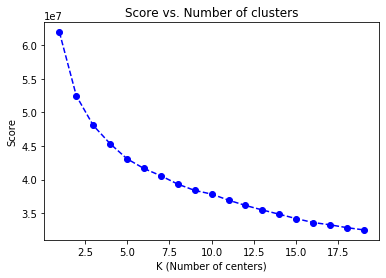

In [32]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K (Number of centers)');
plt.ylabel('Score');
plt.title('Score vs. Number of clusters');

In [33]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(5)
model = kmeans.fit(azdias_pca_20)
azdias_clustering = model.predict(azdias_pca_20)
display(pd.DataFrame(azdias_clustering))

,0
0,1
1,2
2,4
3,3
4,2
...,...
780148,2
780149,3
780150,2
780151,1


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

The above plot shows the correlation between the number of clusters (K) and the score (average distance from the points of a cluster to the cluster's centroid).  
Using the elbow method, I've decided that 5 clusters is a good number to use because at this point, 5 clusters significantly reduces the distance from each point to the center of the cluster, but more clusters doesn't seem to have enough of a substantial impact on the score. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [34]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
display(customers)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,1,3,1,4.0,5,1,5,1,1,2,...,2.0,4.0,2.0,1.0,2.0,5.0,4.0,3.0,8.0,5.0
191648,-1,4,2,2.0,5,1,5,2,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,1.0
191649,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
191650,3,3,2,4.0,2,1,5,1,2,5,...,3.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,4.0,4.0


In [35]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [152]:
def clean_data_customers(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # --- PART 1: Convert missing value codes into NaNs ---
    
    # Check how many missing (not unknown) values in azdias
    df_missing_unknown = df.isnull().sum() 
    
    # Step 1: Remove '[' and ']'
    missing_unknown_values_temp = feat_info['missing_or_unknown'].replace(to_replace=['\[', '\]'], value='', regex=True)

    # Step 2: Split values by ',' to create a list of int
    missing_unknown_values = []
    for value in range(len(missing_unknown_values_temp)):
        missing_unknown_values.append(missing_unknown_values_temp[value].split(','))
    
    # Step 3: Convert values to float (only possible from ints, not strings)
    for i in range(len(missing_unknown_values)):  # Iterate over all features 
        for j in range(len(missing_unknown_values[i])):  # Iterate over all missing values for each feature 

            # Don't touch the missing values already in string format 
            if missing_unknown_values[i][j] in ['', 'X', 'XX']:
                pass

            # Convert the ints into floats 
            else: 
                missing_unknown_values[i][j] = float(missing_unknown_values[i][j])
    
    # Step 4: Fill missing values in azdias with NaN using missing_values
    for values in range(len(missing_unknown_values)):  # Iterate over all features

        # Saving column name
        column_name = feat_info.iloc[values]['attribute']

        # Replace all values in the columns (features) of azdias that are in missing values, with NaN
        df[column_name].replace(missing_unknown_values[values], np.nan, inplace=True) 
    
    
    
    
    
    # --- PART 2: Remove selected columns ---
    
    # Step 1: Calculate missing values after replacing necessary values in azdias
    df_missing_unknown_after_update = df.isnull().sum()

    # Step 2: Create dataframe from number of originally missing values and number of updated missing values 
    s1 = pd.Series(df_missing_unknown, name="Initially missing")
    s2 = pd.Series(df_missing_unknown_after_update, name="Missing after update")
    s = pd.concat([s1, s2], axis=1)
    
    # Step 3: Investigate patterns in the amount of missing data in each column.
    # Number of samples 
    num_samples = df.shape[0]

    # Create Dataframe of percentage of missing values after update 
    df_missing_unknown_after_update_dataframe = pd.DataFrame(df_missing_unknown_after_update, 
                                                             columns = ['Percentage of missing values after update'])
    percentage_missing_values = (df_missing_unknown_after_update_dataframe/num_samples)*100
    
    # Step 4: Let's see which features miss more than 30% of data 
    percentage_missing_values2 = percentage_missing_values[percentage_missing_values['Percentage of missing values after update'] > 30.0]
    
    # Step 5: Drop outliers (features that are missing more than 30% of data)
    outliers = percentage_missing_values2[percentage_missing_values2['Percentage of missing values after update'] > 30.0]
    outliers = outliers.transpose()
    
    # Step 6: Find indices of outliers

    # Values that contain outlier's features names will be marked as True, otherwise False
    feat_info_outlier_idx = feat_info.isin(outliers.columns.values.tolist()) 
    
    # Step 7: Remove the outlier columns from the dataset (azdias). (You'll perform other data
    # engineering tasks such as re-encoding and imputation later.)
    df_no_outliers = df.drop(outliers, axis=1)
    
    # Step 8: Removing outliers from feat_info 
    # Dropping rows from feat_info where corresponding row of feat_info_idx is equal to True. 
    feat_info_no_outliers = feat_info.drop(feat_info_outlier_idx[feat_info_outlier_idx.attribute == True].index) 
    
    # Step 9: Check columsn without any missing values
    df_no_missing_values = percentage_missing_values[percentage_missing_values['Percentage of missing values after update'] == 0.0]
    
    # Step 10: Group features that have the same number of missing values 
    df_missing_unknown_after_update_dataframe = df_missing_unknown_after_update_dataframe.rename(index=str, columns={'Percentage of missing values after update': 'Number of missing values'})
    
    
    
    
    
    # --- PART 3: Remove selected rows ---
    
    # Step 1: How much data is missing in each row of the dataset?
    df_num_missing_row_data = pd.DataFrame(df_no_outliers.isnull().sum(axis=1), columns=['Number of missing data in rows'])
    
    # Step 2: Write code to divide the data into two subsets based on the number of missing values in each row.

    # Add a column that contains the number of missing values in each row 
    df_no_outliers2 = df_no_outliers.join(df_num_missing_row_data)
    
    # Step 3: Keep rows that contain less or equal to 10 missing values 
    df_no_outliers3 = df_no_outliers2[df_no_outliers2['Number of missing data in rows'] <= 10]
    
    # Step 4: Store dataframe of rows that contain more than 10 missings values 
    df_no_outliers_10_features_missings = df_no_outliers2[df_no_outliers2['Number of missing data in rows'] > 10]
    df_no_outliers_10_features_missings.drop(['Number of missing data in rows'], axis=1, inplace=True)
    
    
    
    
    # --- PART 4: Select and re-encode features ---    
    # How many features are there of each data type?
    num_each_feature = feat_info_no_outliers.type.value_counts()
    
    # Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

    # Section off categorical features
    categorical_features = feat_info_no_outliers[feat_info_no_outliers['type'] == 'categorical']
    
    # Visually, we can see that the one binary variable that takes on non-numeric values is 'OST_WEST_KZ'
    # We need to re-encode the values as numbers 
    
    # We'll replace 'O' with 0, and 'W' with 1
    df_no_outliers3['OST_WEST_KZ'] = df_no_outliers3['OST_WEST_KZ'].replace({'O': 0.0, 'W': 1.0})

    # To determine, of the remaining variables, 
    # which are binary categoricals and which are multi-level categoricals,
    # we'll create a list to keep track of the features that are multi-level categoricals 

    multi_level_categorical_features = []
    for feature in categorical_features['attribute']:  # Iterate over all categorical features 

        # Save list of unique values 
        unique_values = df_no_outliers3[feature].unique() 

        # Save features that contain more than 2 values 
        if unique_values.size > 2: 
            multi_level_categorical_features.append(feature)
    
    # Re-encode multi-level categorical features 
    df_multi_categorical = pd.get_dummies(df_no_outliers3, columns=multi_level_categorical_features)
    
    # ---
    
    # Display mixed-type features
    mixed_features = feat_info_no_outliers[feat_info_no_outliers['type'] == 'mixed']
    
    # See which values are unique in each mixed feature
    for feature in mixed_features['attribute']:  # Iterate over all mixed features
        unique_values = df_multi_categorical[feature].unique()
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

    # "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: 
    # - generation by decade
    # - movement (mainstream vs. avantgarde)
    # - nation (east vs. west) 

    # While there aren't enough levels to disentangle east from west, 
    # we'll should create two new variables to capture the other two dimensions: 
    # - an interval-type variable for decade
    # - a binary variable for movement

    # We'll copy feature "PRAEGENDE_JUGENDJAHRE" to two new features:
    # - PRAEGENDE_JUGENDJAHRE_AM (avantgarde vs. mainstream)
    # - PRAEGENDE_JUGENDJAHRE_DC (decade)

    df_new = df_multi_categorical
    df_new['PRAEGENDE_JUGENDJAHRE_AM'] = df_multi_categorical['PRAEGENDE_JUGENDJAHRE']
    df_new['PRAEGENDE_JUGENDJAHRE_DC'] = df_multi_categorical['PRAEGENDE_JUGENDJAHRE']
    
    # Encoding PRAEGENDE_JUGENDJAHRE_DC and PRAEGENDE_JUGENDJAHRE_AM

    # Define encoding dictionary for PRAEGENDE_JUGENDJAHRE_DC
    dict_DC = {1: 40.0,
               2: 40.0, 
               3: 50.0, 
               4: 50.0,
               5: 60.0,
               6: 60.0,
               7: 60.0,
               8: 70.0,
               9: 70.0,
               10: 80.0,
               11: 80.0,
               12: 80.0,
               13: 80.0,
               14: 90.0,
               15: 90.0}

    # Replace PRAEGENDE_JUGENDJAHRE_DC with decade values 
    df_new['PRAEGENDE_JUGENDJAHRE_DC'] = df_new['PRAEGENDE_JUGENDJAHRE_DC'].replace(dict_DC)

    # Define encoding dictionary for PRAEGENDE_JUGENDJAHRE_AM 
    # Encode Mainstream as 0 and Avantgarde as 1
    dict_AM = {1: 0.0,
               2: 1.0,
               3: 0.0,
               4: 1.0,
               5: 0.0,
               6: 1.0,
               7: 1.0,
               8: 0.0,
               9: 1.0,
               10: 0.0,
               11: 1.0,
               12: 0.0,
               13: 1.0,
               14: 0.0, 
               15: 1.0}

    # Replace PRAEGENDE_JUGENDJAHRE_AM with avantgarde and mainstream values 
    df_new['PRAEGENDE_JUGENDJAHRE_AM'] = df_new['PRAEGENDE_JUGENDJAHRE_AM'].replace(dict_AM)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    # "CAMEO_INTL_2015" combines information on two axes: 
    # - wealth
    # - life stage

    # We'll break up the two-digit codes by their 'tens'-place and 'ones'-place digits 
    # into two new ordinal variables (which, for the purposes of this project, is equivalent to 
    # just treating them as their raw numeric values) 

    # Wealth can be coded as (in the new feature, CAMEO_INTL_2015_WL): 
    # - Wealthy Households: 1
    # - Prosperous Households: 2
    # - Comfortable Households: 3
    # - Less Affluent Households: 4
    # - Poorer Households: 5

    # Life can be coded as (in the new feature, CAMEO_INTL_2015_LS): 
    # - Pre-Family: 0
    # - Young Couples: 1
    # - Families: 2
    # - Older Families: 3 
    # - Elders: 4

    # We'll copy feature "CAMEO_INTL_2015" to two new features:
    # - CAMEO_INTL_2015_WL (wealth)
    # - CAMEO_INTL_2015_LS (life stage)

    df_new['CAMEO_INTL_2015_WL'] = df_new['CAMEO_INTL_2015']
    df_new['CAMEO_INTL_2015_LS'] = df_new['CAMEO_INTL_2015']

    # Creating wealth encodings 
    dict_WL = {'11': 1.0,
               '12': 1.0,
               '13': 1.0,
               '14': 1.0,
               '15': 1.0,
               '21': 2.0,
               '22': 2.0,
               '23': 2.0,
               '24': 2.0,
               '25': 2.0,
               '31': 3.0,
               '32': 3.0,
               '33': 3.0,
               '34': 3.0, 
               '35': 3.0,
               '41': 4.0,
               '42': 4.0,
               '43': 4.0,
               '44': 4.0, 
               '45': 4.0,
               '51': 5.0,
               '52': 5.0,
               '53': 5.0,
               '54': 5.0, 
               '55': 5.0}

    # Creating wealth encodings
    df_new['CAMEO_INTL_2015_WL'] = df_new['CAMEO_INTL_2015_WL'].replace(dict_WL)

    # Creating life stage encodings 
    dict_LS = {'11': 1.0,
               '12': 2.0,
               '13': 3.0,
               '14': 4.0,
               '15': 5.0,
               '21': 1.0,
               '22': 2.0,
               '23': 3.0,
               '24': 4.0,
               '25': 5.0,
               '31': 1.0,
               '32': 2.0,
               '33': 3.0,
               '34': 4.0, 
               '35': 5.0,
               '41': 1.0,
               '42': 2.0,
               '43': 3.0,
               '44': 4.0, 
               '45': 5.0,
               '51': 1.0,
               '52': 2.0,
               '53': 3.0,
               '54': 4.0, 
               '55': 5.0}

    # Creating life stage encodings 
    df_new['CAMEO_INTL_2015_LS'] = df_new['CAMEO_INTL_2015_LS'].replace(dict_LS)

    # Drop unnecessary rows 
    df_new.drop(['Number of missing data in rows',
                 'PRAEGENDE_JUGENDJAHRE', 
                 'CAMEO_INTL_2015', 
                 'WOHNLAGE', 
                 'PLZ8_BAUMAX'], axis=1, inplace=True)    
    
    
    
    
    
    # --- PART 5: Return the cleaned dataframe ---
    return df_new, df_no_outliers, df_no_outliers2, df_no_outliers_10_features_missings

In [153]:
# Apply the same feature wrangling, selection, and engineering steps to the customer demographics, like for 
# the general population using the clean_data() 
customers_cleaned, customers_no_outliers, customers_no_outliers2, customers_no_outliers_10_features_missing = clean_data_customers(customers)
display(customers_cleaned)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_WL,CAMEO_INTL_2015_LS
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,1.0,50.0,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0,0,1.0,50.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0.0,40.0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,0,0,0,0.0,70.0,4.0,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,0,0,0,1.0,50.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191646,2.0,2,2,1,5,1,2,5,0,2.0,...,0,0,0,0,0,0,0.0,70.0,1.0,4.0
191647,3.0,1,5,1,5,1,1,2,1,3.0,...,0,0,0,0,0,0,1.0,50.0,1.0,4.0
191649,4.0,1,5,1,5,1,1,2,1,2.0,...,0,0,0,0,0,0,1.0,50.0,2.0,4.0
191650,3.0,2,2,1,5,1,2,5,0,2.0,...,0,0,0,0,0,0,0.0,70.0,2.0,4.0


In [154]:
# customers_cleaned has 192 features, while azdias_cleaned has 195 features 
# We need to add in missing features in customers_cleaned 
# We need to do this so we can re-use the PCA models that were fitting to the general population 

print('Features of azdias_cleaned that aren\'t in customers_cleaned:')
for i in range(len(azdias_cleaned.columns.tolist())):
    if not azdias_cleaned.columns.tolist()[i] in customers_cleaned.columns.tolist():
        print('Index', i, ':', azdias_cleaned.columns.tolist()[i])

Features of azdias_cleaned that aren't in customers_cleaned:
Index 47 : KKK
Index 50 : REGIOTYP
Index 135 : GEBAEUDETYP_5.0


In [155]:
# Add missing features to customers_cleaned
customers_cleaned['KKK'] = pd.DataFrame(np.zeros(shape=(customers_cleaned.shape[0], )))
customers_cleaned['REGIOTYP'] = pd.DataFrame(np.zeros(shape=(customers_cleaned.shape[0], )))
customers_cleaned['GEBAEUDETYP_5.0'] = pd.DataFrame(np.zeros(shape=(customers_cleaned.shape[0], )))

display(customers_cleaned)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_WL,CAMEO_INTL_2015_LS,KKK,REGIOTYP,GEBAEUDETYP_5.0
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,1.0,50.0,1.0,3.0,0.0,0.0,0.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,1.0,50.0,3.0,4.0,0.0,0.0,0.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0,0,0,0.0,40.0,2.0,4.0,0.0,0.0,0.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,0.0,70.0,4.0,1.0,0.0,0.0,0.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,1.0,50.0,3.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191646,2.0,2,2,1,5,1,2,5,0,2.0,...,0,0,0,0.0,70.0,1.0,4.0,NaN,NaN,NaN
191647,3.0,1,5,1,5,1,1,2,1,3.0,...,0,0,0,1.0,50.0,1.0,4.0,NaN,NaN,NaN
191649,4.0,1,5,1,5,1,1,2,1,2.0,...,0,0,0,1.0,50.0,2.0,4.0,NaN,NaN,NaN
191650,3.0,2,2,1,5,1,2,5,0,2.0,...,0,0,0,0.0,70.0,2.0,4.0,NaN,NaN,NaN


In [156]:
# Remove NaN values 
customers_cleaned_imputed = pd.DataFrame(imputer.transform(customers_cleaned))
customers_cleaned_imputed.columns = customers_cleaned.columns
customers_cleaned_imputed.index = customers_cleaned.index
display(customers_cleaned_imputed)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_WL,CAMEO_INTL_2015_LS,KKK,REGIOTYP,GEBAEUDETYP_5.0
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,1.0,50.0,1.0,3.0,0.000000,0.000000,0.000000
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,0.0,0.0,0.0,1.0,50.0,3.0,4.0,0.000000,0.000000,0.000000
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,40.0,2.0,4.0,0.000000,0.000000,0.000000
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,70.0,4.0,1.0,0.000000,0.000000,0.000000
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,0.0,0.0,0.0,1.0,50.0,3.0,4.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191646,2.0,2.0,2.0,1.0,5.0,1.0,2.0,5.0,0.0,2.0,...,0.0,0.0,0.0,0.0,70.0,1.0,4.0,73.236763,3.274299,2.870714
191647,3.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,3.0,...,0.0,0.0,0.0,1.0,50.0,1.0,4.0,73.236763,3.274299,2.870714
191649,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,0.0,0.0,0.0,1.0,50.0,2.0,4.0,73.236763,3.274299,2.870714
191650,3.0,2.0,2.0,1.0,5.0,1.0,2.0,5.0,0.0,2.0,...,0.0,0.0,0.0,0.0,70.0,2.0,4.0,73.236763,3.274299,2.870714


In [157]:
# Apply feature scaling 
customers_cleaned_imputed_scaled = pd.DataFrame(scaler.transform(customers_cleaned_imputed))
customers_cleaned_imputed_scaled.columns = customers_cleaned_imputed.columns
customers_cleaned_imputed_scaled.index = customers_cleaned_imputed.index
display(customers_cleaned_imputed_scaled)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_WL,CAMEO_INTL_2015_LS,KKK,REGIOTYP,GEBAEUDETYP_5.0
0,1.181706,-1.043411,1.414618,-1.151087,1.133828,-1.247812,-0.454983,-0.817895,1.882535,-1.630686,...,-0.151267,-0.163813,-0.191144,5.512776,266.756260,11.212044,6.724752,-5.109314,-2.239515e+00,-1.933936
2,1.181706,0.958395,1.414618,-1.151087,1.133828,-1.247812,0.980071,0.611953,1.882535,-0.276116,...,-0.151267,-0.163813,-0.191144,5.512776,266.756260,33.814511,9.150537,-5.109314,-2.239515e+00,-1.933936
3,1.181706,-1.043411,1.414618,-1.151087,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.276116,...,-0.151267,-0.163813,-0.191144,-0.181397,213.366133,22.513277,9.150537,-5.109314,-2.239515e+00,-1.933936
4,0.198771,-1.043411,-0.036761,-1.151087,0.407468,0.788502,1.697599,-0.817895,-0.531199,1.078455,...,-0.151267,-0.163813,-0.191144,-0.181397,373.536515,45.115744,1.873182,-5.109314,-2.239515e+00,-1.933936
5,0.198771,-1.043411,1.414618,-1.151087,1.133828,-1.247812,-0.454983,-0.102971,1.882535,1.078455,...,-0.151267,-0.163813,-0.191144,5.512776,266.756260,33.814511,9.150537,-5.109314,-2.239515e+00,-1.933936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191646,-0.784164,0.958395,-0.762450,-1.151087,1.133828,-1.247812,-0.454983,1.326876,-0.531199,-0.276116,...,-0.151267,-0.163813,-0.191144,-0.181397,373.536515,11.212044,9.150537,0.000000,6.074856e-16,0.000000
191647,0.198771,-1.043411,1.414618,-1.151087,1.133828,-1.247812,-1.172510,-0.817895,1.882535,1.078455,...,-0.151267,-0.163813,-0.191144,5.512776,266.756260,11.212044,9.150537,0.000000,6.074856e-16,0.000000
191649,1.181706,-1.043411,1.414618,-1.151087,1.133828,-1.247812,-1.172510,-0.817895,1.882535,-0.276116,...,-0.151267,-0.163813,-0.191144,5.512776,266.756260,22.513277,9.150537,0.000000,6.074856e-16,0.000000
191650,0.198771,0.958395,-0.762450,-1.151087,1.133828,-1.247812,-0.454983,1.326876,-0.531199,-0.276116,...,-0.151267,-0.163813,-0.191144,-0.181397,373.536515,22.513277,9.150537,0.000000,6.074856e-16,0.000000


In [158]:
# Perform PCA
customers_pca_20 = pca_20.transform(customers_cleaned_imputed_scaled)
display(pd.DataFrame(customers_pca_20))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-35.267713,-120.224082,-4.666158,101.955172,21.069208,-45.343259,44.738395,51.752030,-23.966752,36.453466,31.073733,-20.479552,13.868510,49.691154,32.396544,10.432559,-15.208287,50.898150,18.513941,13.126995
1,-5.457893,-37.508679,-1.998941,40.714700,7.305949,-26.476345,24.322273,-3.605431,-4.359791,24.093887,13.283765,-9.810019,-3.640101,46.362405,11.390569,4.834780,-14.169091,14.610973,2.804610,-5.013595
2,-20.944601,-74.195196,-2.256726,64.079936,12.823867,-29.047487,29.088011,29.282969,-11.107793,24.462996,21.825352,-12.572808,3.445364,36.674305,17.699939,2.756188,-17.015545,27.648691,5.099006,2.229451
3,-0.911876,-49.110408,-0.526799,47.112517,16.772677,-34.915102,27.328131,-6.631406,-7.152273,32.772758,19.238820,-13.157558,-8.643361,62.691895,14.997099,10.514666,-22.388785,12.664739,2.599327,-6.117965
4,-33.381615,-116.989329,-6.822239,100.687172,18.476275,-43.199908,40.154033,48.997607,-21.263028,35.423448,35.389967,-20.363111,7.374457,46.949931,27.285363,-1.091994,-16.865679,47.420385,6.233674,1.962844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139254,18.003101,-4.331022,3.043783,10.985622,6.049308,-27.466805,15.215573,-42.230091,1.389150,25.455371,2.212800,-5.215900,-8.473959,64.514572,5.247556,22.491880,-16.233628,-3.572194,12.205061,-2.555061
139255,-11.650054,-64.115620,-0.014649,58.063926,10.892331,-33.865920,26.670801,10.081508,-11.711454,27.908859,17.905963,-11.908814,3.601615,49.400348,17.640332,14.544941,-12.311055,24.669063,15.071025,6.185220
139256,-14.226759,-62.596228,-1.373151,59.009453,13.396308,-32.851885,27.897270,13.793318,-11.490887,26.235115,21.027846,-11.937951,0.909534,44.570971,18.264045,5.345344,-19.246887,22.829325,6.838360,-2.754961
139257,8.505030,-20.081291,0.488917,29.002842,9.383298,-30.751916,17.523238,-25.733552,0.463101,26.261939,10.481160,-8.218069,-9.304834,61.148608,7.177394,10.071925,-23.097664,2.709337,5.536642,-10.120353


In [159]:
# Re-fit k-means model from the general demographics data, and apply their transformations to the customers data
customers_clustering = model.predict(customers_pca_20)
display(pd.DataFrame(customers_clustering))

,0
0,2
1,2
2,2
3,2
4,2
...,...
139254,1
139255,2
139256,2
139257,1


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [160]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1673f79e8>]],
      dtype=object)

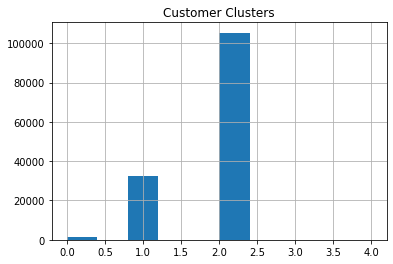

In [161]:
# Plot customer clustering
customer_clustering_df = pd.DataFrame(customers_clustering, columns=['Customer Clusters'])
customer_clustering_df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1654ff7b8>]],
      dtype=object)

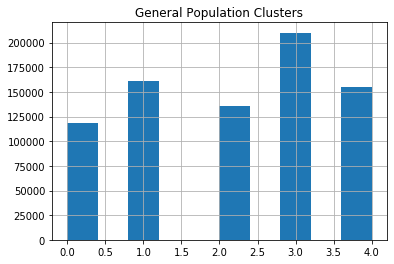

In [162]:
# Plot general demographic clustering
azdias_clustering_df = pd.DataFrame(azdias_clustering, columns=['General Population Clusters'])
azdias_clustering_df.hist()

In [163]:
# Calculate percentage genereal clusters account for 
azdias_clustering_percentage = pd.DataFrame(azdias_clustering_df['General Population Clusters'].value_counts())*100 / (azdias_no_outliers.shape[0])
print('Percentage each cluster accounts for:')
display(azdias_clustering_percentage)

# Calculate percentage of dropped rows where missing values were present in more than 10 features
azdias_percentage_dropped_rows = azdias_no_outliers2[azdias_no_outliers2['Number of missing data in rows'] > 10].shape[0] * 100 / azdias_no_outliers.shape[0]
print('Percentage of dropped rows, where missing values are present in more than 10 features:', str(azdias_percentage_dropped_rows) + '%')
print('Adding the dropped rows as a cluster...')

# Add dropped rows as a separate cluster
cluster_to_add = pd.Series(azdias_percentage_dropped_rows, index=['General Population Clusters'])
azdias_clustering_percentage = azdias_clustering_percentage.append(cluster_to_add, ignore_index=True)
azdias_clustering_percentage.sort_index(inplace=True)
display(azdias_clustering_percentage)

# Ensure percentage of clusters adds to 100%
print('Ensure percentage of clusters adds to 100%:')
print(azdias_clustering_percentage.sum())

Percentage each cluster accounts for:


,General Population Clusters
3,23.569463
1,18.031891
4,17.410272
2,15.186918
0,13.339003


Percentage of dropped rows, where missing values are present in more than 10 features: 12.462453196233033%
Adding the dropped rows as a cluster...


,General Population Clusters
0,23.569463
1,18.031891
2,17.410272
3,15.186918
4,13.339003
5,12.462453


Ensure percentage of clusters adds to 100%:
General Population Clusters    100.0
dtype: float64


In [164]:
# Calculate percentage customer clusters account for 
customers_clustering_percentage = pd.DataFrame(customer_clustering_df['Customer Clusters'].value_counts())*100 / (customers_no_outliers.shape[0])
print('Percentage each cluster accounts for:')
display(customers_clustering_percentage)

# Calculate percentage of dropped rows where missing values were present in more than 10 features
customers_percentage_dropped_rows = customers_no_outliers2[customers_no_outliers2['Number of missing data in rows'] > 10].shape[0] * 100 / customers_no_outliers.shape[0]
print('Percentage of dropped rows, where missing values are present in more than 10 features:', str(customers_percentage_dropped_rows) + '%')
print('Adding the dropped rows as a cluster...')

# Add dropped rows as a separate cluster
cluster_to_add = pd.Series(customers_percentage_dropped_rows, index=['Customer Clusters'])
customers_clustering_percentage = customers_clustering_percentage.append(cluster_to_add, ignore_index=True)
customers_clustering_percentage.sort_index(inplace=True)
display(customers_clustering_percentage)

# Ensure percentage of clusters adds to 100%
print('Ensure percentage of clusters adds to 100%:')
print(customers_clustering_percentage.sum())

Percentage each cluster accounts for:


,Customer Clusters
2,54.988730
1,16.879553
0,0.776407
3,0.015132
4,0.002609


Percentage of dropped rows, where missing values are present in more than 10 features: 27.337570179283283%
Adding the dropped rows as a cluster...


,Customer Clusters
0,54.988730
1,16.879553
2,0.776407
3,0.015132
4,0.002609
5,27.337570


Ensure percentage of clusters adds to 100%:
Customer Clusters    100.0
dtype: float64


In [165]:
# Creating a dataframe for which cluster each sample of the general population belongs to
azdias_sample_clustering = pd.DataFrame(azdias_clustering, columns=['Clusters'])
azdias_sample_clustering.index = azdias_cleaned_imputed_scaled.index
display(azdias_sample_clustering)

,Clusters
1,1
2,2
3,4
4,3
5,2
...,...
891216,2
891217,3
891218,2
891219,1


In [166]:
# Creating a dataframe for which cluster each sample of the customers belongs to
customers_sample_clustering = pd.DataFrame(customers_clustering, columns=['Clusters'])
customers_sample_clustering.index = customers_cleaned_imputed_scaled.index
display(customers_sample_clustering)

,Clusters
0,2
2,2
3,2
4,2
5,2
...,...
191646,1
191647,2
191649,2
191650,1


### What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?  
From the histograms above (azdias_clustering_df and customer_clustering_df), we can see that cluster 3 is massively overrepresented in the customer data, compare to the general population.  
This suggests the people in cluster 3 are a target audience for the company.

In [218]:
# Get customer clusters that each sample is in
customers_feature_clusters = customers_cleaned.join(customers_sample_clustering)
display(customers_feature_clusters)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_WL,CAMEO_INTL_2015_LS,KKK,REGIOTYP,GEBAEUDETYP_5.0,Clusters
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,1.0,50.0,1.0,3.0,0.0,0.0,0.0,2
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,1.0,50.0,3.0,4.0,0.0,0.0,0.0,2
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0,0,0.0,40.0,2.0,4.0,0.0,0.0,0.0,2
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0.0,70.0,4.0,1.0,0.0,0.0,0.0,2
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,1.0,50.0,3.0,4.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191646,2.0,2,2,1,5,1,2,5,0,2.0,...,0,0,0.0,70.0,1.0,4.0,NaN,NaN,NaN,1
191647,3.0,1,5,1,5,1,1,2,1,3.0,...,0,0,1.0,50.0,1.0,4.0,NaN,NaN,NaN,2
191649,4.0,1,5,1,5,1,1,2,1,2.0,...,0,0,1.0,50.0,2.0,4.0,NaN,NaN,NaN,2
191650,3.0,2,2,1,5,1,2,5,0,2.0,...,0,0,0.0,70.0,2.0,4.0,NaN,NaN,NaN,1


In [219]:
# Get samples that are in Cluster 3
customers_feature_clusters = customers_feature_clusters[customers_feature_clusters['Clusters'] == 3]
display(customers_feature_clusters)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_WL,CAMEO_INTL_2015_LS,KKK,REGIOTYP,GEBAEUDETYP_5.0,Clusters
8443,4.0,2,2,1,5,1,1,5,0,1.0,...,0,1,0.0,40.0,5.0,5.0,0.0,0.0,0.0,3
9019,4.0,2,2,1,5,1,1,5,0,2.0,...,0,1,0.0,40.0,5.0,5.0,0.0,0.0,0.0,3
14894,4.0,2,3,1,5,1,2,5,0,2.0,...,0,1,NaN,NaN,5.0,5.0,0.0,0.0,0.0,3
23758,4.0,2,3,1,4,2,1,5,0,2.0,...,0,1,NaN,NaN,5.0,5.0,0.0,0.0,0.0,3
25124,4.0,2,2,1,5,1,1,5,0,2.0,...,0,1,0.0,40.0,5.0,5.0,0.0,0.0,0.0,3
27054,4.0,2,3,1,5,1,1,5,0,2.0,...,0,1,0.0,40.0,5.0,5.0,0.0,0.0,0.0,3
36811,4.0,2,2,1,5,2,2,5,0,2.0,...,0,0,0.0,40.0,5.0,1.0,0.0,0.0,0.0,3
40932,4.0,2,3,1,5,1,1,5,1,2.0,...,0,0,1.0,40.0,5.0,4.0,0.0,0.0,0.0,3
50959,4.0,2,3,1,5,1,2,5,0,2.0,...,0,1,NaN,NaN,5.0,5.0,0.0,0.0,0.0,3
52004,4.0,2,2,1,5,1,1,5,0,2.0,...,0,1,NaN,NaN,5.0,5.0,0.0,0.0,0.0,3


In [230]:
# Get mode values of features of samples that belong to Cluster 1
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame(customers_feature_clusters.mode()).transpose().drop([1, 2], axis=1))

,0
ALTERSKATEGORIE_GROB,4.0
ANREDE_KZ,2.0
FINANZ_MINIMALIST,2.0
FINANZ_SPARER,1.0
FINANZ_VORSORGER,5.0
FINANZ_ANLEGER,1.0
FINANZ_UNAUFFAELLIGER,1.0
FINANZ_HAUSBAUER,5.0
GREEN_AVANTGARDE,0.0
HEALTH_TYP,2.0


We'll investigate some of the values that characterize cluster 3:
- ALTERSKATEGORIE_GROB (Estimated age): > 60 years old
- ANREDE_KZ (Gender): Female
- FINANZ_MINIMALIST (Financial topology, low financial interest): High
- FINANZ_ANLEGER (Financial topology, inverstor): Very high 
- FINANZ_HAUSBAUER (Financial topology, homeowner): Very low
- LP_LEBENSPHASE_FEIN (Life stage, fine scale): Single low-income earners at retirement age
- LP_FAMILIE_FEIN (Family type, fine scale): Single
- LP_STATUS_FEIN (Social status, fine scale): Typical low-income earners
- NATIONALITAET_KZ (Nationality based on given name analysis): German-sounding
- SEMIO_SOZ (Personality topology, socially-minded): Low affinity
- SEMIO_FAM (Personality topology, family-minded): Very high affinity
- SEMIO_RAT (Personality topology, rational): High affinity
- SEMIO_KAEM (Personality topology, combative attitude): Very low affinity
- SEMIO_TRADV (Personality topology, traditional): Highest affinity
- HH_EINKOMMEN_SCORE (Estimated household net income): Very low income
- GEBAEUDETYP (Type of building): Mixed (residential and company) building
- CAMEO_INTL_2015_WL (Wealth topology): Poorer Households
- CAMEO_INTL_2015_LS (Life stage topology): Elders In Retirement
- INNENSTADT (Distance to city center): In city center
- MOBI_REGIO (Movement patterns): Very high movement
- ORTSGR_KLS9 (Size of community): 10,001 to  20,000 inhabitants  

The typical person in the target group is a female elder (above 60 years old) who's single, is a low-income earner, with a low financial interest, is an investor, and doesn't own a home. She's german-sounding, not very social nor combative, yet very rational, family-oriented, and traditional. She lives in a part residental and part company building in the city center (downtown) that moves around a lot. Her community has between 10,000 and 20,000 inhabitants. 

### What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?  
From the histograms above (azdias_clustering_df and customer_clustering_df), we can see that clusters 1, 2, 4, and 5 are massively underrepresented in the customer data, compare to the general population.  
This suggests the people in cluster 1, 2, 4, and 5 are outside of the company's target demographic. 

In [240]:
# Get genereal population clusters that each sample is in
azdias_feature_clusters = azdias_cleaned.join(azdias_sample_clustering)
display(azdias_feature_clusters)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_WL,CAMEO_INTL_2015_LS,Clusters
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0.0,90.0,5.0,1.0,1
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,1.0,90.0,2.0,4.0,2
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0.0,70.0,1.0,2.0,4
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0.0,70.0,4.0,3.0,3
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0.0,50.0,5.0,4.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,1,4,2,5,4,4,0,3.0,...,0,0,0,0,0,0.0,90.0,4.0,1.0,2
891217,2.0,1,3,3,3,2,2,3,0,NaN,...,0,0,0,1,0,0.0,80.0,5.0,1.0,3
891218,2.0,2,2,4,2,5,4,3,0,1.0,...,0,0,0,0,0,0.0,90.0,2.0,4.0,2
891219,1.0,1,1,5,3,5,5,5,0,1.0,...,0,0,0,1,0,0.0,90.0,5.0,1.0,1


In [241]:
# Get samples that are in Cluster 2
azdias_feature_clusters = azdias_feature_clusters[azdias_feature_clusters['Clusters'] == 2]
display(azdias_feature_clusters)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_WL,CAMEO_INTL_2015_LS,Clusters
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,1.0,90.0,2.0,4.0,2
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0.0,50.0,5.0,4.0,2
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0.0,80.0,2.0,2.0,2
7,1.0,1,3,3,4,1,3,2,0,1.0,...,0,0,0,0,0,0.0,70.0,1.0,4.0,2
9,3.0,2,2,4,2,3,5,4,1,2.0,...,0,0,0,0,0,1.0,90.0,1.0,5.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891196,2.0,2,1,5,2,5,4,3,0,2.0,...,0,0,0,0,0,0.0,90.0,2.0,3.0,2
891198,3.0,1,2,5,3,4,5,3,1,3.0,...,0,0,0,0,0,1.0,90.0,1.0,4.0,2
891206,1.0,2,3,4,2,4,4,2,0,3.0,...,0,0,0,0,0,0.0,90.0,2.0,5.0,2
891216,3.0,2,1,4,2,5,4,4,0,3.0,...,0,0,0,0,0,0.0,90.0,4.0,1.0,2


In [242]:
# Get mode values of features of samples that belong to Cluster 2
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame(azdias_feature_clusters.mode()).transpose())

,0
ALTERSKATEGORIE_GROB,1.0
ANREDE_KZ,2.0
FINANZ_MINIMALIST,3.0
FINANZ_SPARER,4.0
FINANZ_VORSORGER,2.0
FINANZ_ANLEGER,5.0
FINANZ_UNAUFFAELLIGER,5.0
FINANZ_HAUSBAUER,2.0
GREEN_AVANTGARDE,0.0
HEALTH_TYP,3.0


We'll investigate some of the values that characterize cluster 2:
- ALTERSKATEGORIE_GROB (Estimated age): < 30 years old
- ANREDE_KZ (Gender): Female
- FINANZ_MINIMALIST (Financial topology, low financial interest): Average
- FINANZ_ANLEGER (Financial topology, inverstor): Very low 
- FINANZ_HAUSBAUER (Financial topology, homeowner): High 
- LP_LEBENSPHASE_FEIN (Life stage, fine scale): Average earners of younger age from multiperson households
- LP_FAMILIE_FEIN (Family type, fine scale): N/A
- LP_STATUS_FEIN (Social status, fine scale): N/A
- NATIONALITAET_KZ (Nationality based on given name analysis): German-sounding
- SEMIO_SOZ (Personality topology, socially-minded): Lowest affinity
- SEMIO_FAM (Personality topology, family-minded): Lowest affinity
- SEMIO_RAT (Personality topology, rational): Average affinity
- SEMIO_KAEM (Personality topology, combative attitude): Average affinity
- SEMIO_TRADV (Personality topology, traditional): Low affinity
- HH_EINKOMMEN_SCORE (Estimated household net income): Lower income
- GEBAEUDETYP (Type of building): Residential building
- CAMEO_INTL_2015_WL (Wealth topology): Prosperous Households
- CAMEO_INTL_2015_LS (Life stage topology): Older Families & Mature Couples
- INNENSTADT (Distance to city center): 10 - 20 km to city center
- MOBI_REGIO (Movement patterns): Low movement
- ORTSGR_KLS9 (Size of community): 10,001 to 20,000 inhabitants

A type of person NOT in the target group is a young female (below 30 years old) who's an average-income earner, from a multiperson household, with an average financial interest, not an investor and owns a home. She's german-sounding, not very social nor family-oriented nor traditional, although reasonably rational and combative. She lives in a residental building around 10-20km to the city center (downtown) and doesn't move around a lot. Her community has between 10,000 and 20,000 inhabitants. 

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Above I've described typical characteristics of a person who this particular company may want to consider advertising to, and typical characteristics of a person who this particular company may want to avoid advertising to.  
There's a separation between a lot of the characteristics. Therefore, the company can take clear measures on which group of people in the general population to advertise to in order to increase profits. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.